## Вводные по кейсу

In [1]:
%%html
<!-- Настроим вывод Markdown таблиц -->
<style>
div.rendered_html table,
.jp-RenderedHTMLCommon table {
    margin-left: 0 !important;
    margin-right: auto !important;
    width: auto !important;
    display: table !important;
    float: none !important;
}
</style>

# Описание данных

## Таблица `Users`


| Поле              | Описание                                       |
|:-------------------|:------------------------------------------------|
| `user_id`         | Уникальный идентификатор пользователя.         |
| `registration_date` | Дата регистрации пользователя.                |
| `age`             | Возраст пользователя.                          |
| `gender`          | Пол.                                |
| `region`          | Регион.                                        |
| `acq_channel`     | Канал привлечения.                             |
| `buyer_segment`   | Сегмент покупателя.                            |
| `cohort_week`     | Неделя привлечения.|
| `cohort_month`    | Месяц привлечения. | 
 

## Таблица `Events`

| Поле          | Описание                                                                 |
|:---------------|:--------------------------------------------------------------------------|
| `event_id`    | Уникальный идентификатор события.                                        |
| `user_id`     | Идентификатор пользователя.                                              |
| `event_date`  | Дата события.                                                            |
| `event_type`  | Тип события.   |
| `os`          | Операционная система.               |
| `device`      | Тип устройства.                                |
| `product_name`| Наименование товара, к которому относится событие (если применимо).      |
| `event_week`  | Неделя события.                                          |
| `event_month` | Месяц события .                                           |
  
   
## Таблица `Orders`

| Поле          | Описание                                                                 |
|:---------------|:--------------------------------------------------------------------------|
| `order_id`    | Уникальный идентификатор заказа.                                         |
| `user_id`     | Идентификатор пользователя, который сделал заказ |
| `order_date`  | Дата и время оформления заказа.                                          |
| `product_name`| Наименование товара.                                                     |
| `quantity`    | Количество единиц товара в заказе.                                       |
| `unit_price`  | Цена за одну единицу товара.                                             |
| `total_price` | Итоговая сумма заказа.                                                   |
| `category_name` | Наименование категории товара.                                         |
| `order_week`  | Неделя заказа.                                           |
| `order_month` | Месяц заказа.                                            |


## Таблица `Campaign_costs`

| Поле         | Описание                                                                 |
|:--------------|:--------------------------------------------------------------------------|
| `acq_channel`| Канал привлечения.  |
| `spend_month`| Месяц, в который был потрачен бюджет (отражает период, в котором были привлечены пользователи)                      |
| `budget`     | Маркетинговый бюджет (в денежном выражении), потраченный на данный канал в указанном месяце.                           |

## Описание событий

| Событие             | Описание                                                                                  |
|:---------------------|:-------------------------------------------------------------------------------------------|
| `page_view`         | Открытие любой страницы сайта или приложения пользователем.                                |
| `product_view`      | Просмотр страницы конкретного товара.                                                     |
| `product_click`     | Клик по товару (например, из списка товаров или на баннере).                              |
| `add_to_cart`       | Добавление товара в корзину.                                                              |
| `remove_from_cart`  | Удаление товара из корзины.                                                               |
| `search`            | Выполнение поиска по сайту или приложению.                                                |
| `filter_apply`      | Применение фильтра (например, по цене, бренду, категории).                                |
| `checkout_start`    | Начало оформления заказа (переход к оформлению корзины).                                  |
| `checkout_complete` | Завершение оформления заказа (не гарантирует покупку, покупка зависит от факта оплаты).                                          |
| `user_login`        | Вход пользователя в личный кабинет или аккаунт.                                           |
| `user_logout`       | Выход пользователя из аккаунта.                                                           |
| `wishlist_add`      | Добавление товара в список желаемого (wishlist).                                          |
| `category_view`     | Просмотр страницы категории товаров.                                                      |
| `banner_click`      | Клик по рекламному баннеру на сайте или в приложении.                                     |
| `promo_view`        | Просмотр промо-акции или специального предложения.                                        |


## Выручка маркетплейса = 5% от total_price

## План проекта
- Первичный анализ и сбор данных.
- Обзор ключевых метрик.
- Оценка метрик монетизации и юнит-экономики.
- Поиск инсайтов и точек роста. Сегментация и формулирование гипотез.
- Подготовка эксперимента и подведение его итогов.

# Блок кода и расчета метрик

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

# Настройки отображения DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', 50)

In [3]:
pa_marketplace_orders = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_orders.csv')
pa_marketplace_campaign_costs = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_campaign_costs.csv', index_col=0)
pa_marketplace_users = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_users.csv')
pa_marketplace_events = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_events.csv')

In [4]:
# Познакомимся с данными в pa_marketplace_orders
display(pa_marketplace_orders.sample(10))
display(pa_marketplace_orders.info())

# Преобразуем даты в datetime64
pa_marketplace_orders['order_date'] = pd.to_datetime(pa_marketplace_orders['order_date'], errors='coerce')
pa_marketplace_orders['order_week'] = pd.to_datetime(pa_marketplace_orders['order_week'], errors='coerce')
pa_marketplace_orders['order_month'] = pd.to_datetime(pa_marketplace_orders['order_month'], errors='coerce')

# Посмотрим дубликаты
display(pa_marketplace_orders.duplicated().sum())
display(pa_marketplace_orders.duplicated(subset=['order_id', 'user_id']).sum())

# Проверяем на экстремальные значения
display(pa_marketplace_orders[['quantity', 'unit_price', 'total_price', 'order_date', 'order_week', 'order_month']].agg([min, max]))

order_id  user_id               order_date             product_name  \
30780     31007    40590  2024-12-20 15:29:32.000           Майка борцовка   
3395       3396     3251  2024-03-27 04:37:43.000          Коврик для йоги   
415         416      330  2024-02-18 18:02:57.000     Самокат трехколесный   
11776     11777    10552  2024-09-17 20:30:26.000  Леггинсы компрессионные   
19653     19656    18061  2024-07-02 18:56:54.000            Сапоги зимние   
31205     31495    42806  2024-12-19 02:36:53.000     Пластырь медицинский   
5588       5589     5351  2024-03-27 06:56:01.000            Микроволновка   
8967       8968     8164  2024-04-06 03:17:56.000      Пазл 1000 элементов   
7029       7030     6654  2024-06-13 11:35:03.000        Поло Ralph Lauren   
17361     17362    15742  2024-09-12 15:12:17.000       Свитер с капюшоном   

       quantity  unit_price  total_price         category_name  order_week  \
30780         3     4645.38     13936.14     Одежда для спорта  2024-12-16   
3395          1     5674.59      5674.59  Спортивный инвентарь  2024-03-25   
415           2     5072.14     10144.28       Детские игрушки  2024-02-12   
11776         2     2182.31      4364.62     Одежда для спорта  2024-09-16   
19653         3     8013.05     24039.15         Обувь мужская  2024-07-01   
31205         2     7883.33     15766.66    Медицинские товары  2024-12-16   
5588          1    10659.82     10659.82       Бытовая техника  2024-03-25   
8967          1     5544.26      5544.26       Детские игрушки  2024-04-01   
7029          2     5446.69     10893.38        Мужская одежда  2024-06-10   
17361         2     3646.64      7293.28        Детская одежда  2024-09-09   

      order_month  
30780  2024-12-01  
3395   2024-03-01  
415    2024-02-01  
11776  2024-09-01  
19653  2024-07-01  
31205  2024-12-01  
5588   2024-03-01  
8967   2024-04-01  
7029   2024-06-01  
17361  2024-09-01

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31357 entries, 0 to 31356
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_id       31357 non-null  int64  
 1   user_id        31357 non-null  int64  
 2   order_date     31357 non-null  object 
 3   product_name   31357 non-null  object 
 4   quantity       31357 non-null  int64  
 5   unit_price     31357 non-null  float64
 6   total_price    31357 non-null  float64
 7   category_name  31357 non-null  object 
 8   order_week     31357 non-null  object 
 9   order_month    31357 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 2.4+ MB


None

0

0

quantity  unit_price  total_price          order_date order_week  \
min         1      339.00       339.00 2024-01-01 08:03:45 2024-01-01   
max         3    63932.38    191797.14 2024-12-31 23:00:53 2024-12-30   

    order_month  
min  2024-01-01  
max  2024-12-01

In [5]:
# Познакомимся с данными в pa_marketplace_campaign_costs
pa_marketplace_campaign_costs.index.name = None
display(pa_marketplace_campaign_costs.sample(10))
display(pa_marketplace_campaign_costs.info())

# # Преобразуем даты в datetime64
pa_marketplace_campaign_costs['spend_month'] = pd.to_datetime(pa_marketplace_campaign_costs['spend_month'], errors='coerce')

# # Посмотрим дубликаты
display(pa_marketplace_campaign_costs.duplicated().sum())
display(pa_marketplace_campaign_costs.duplicated(subset=['acq_channel', 'spend_month']).sum())

# Проверяем на экстремальные значения
display(pa_marketplace_campaign_costs[['spend_month', 'budget']].agg([min, max]))

acq_channel spend_month         budget
2         Affiliate  2024-03-01  164543.475000
45     Social Media  2024-10-01  108551.537500
14           Direct  2024-03-01    8940.163125
83           Direct  2025-01-01    6882.217087
70           TikTok  2024-01-01  170131.137500
72           TikTok  2024-03-01  171643.862500
77           TikTok  2024-08-01  966783.500000
66              SEO  2024-09-01   48213.825000
33  Email Marketing  2024-10-01   38609.860000
29  Email Marketing  2024-06-01   36863.137500

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 87
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acq_channel  88 non-null     object 
 1   spend_month  88 non-null     object 
 2   budget       88 non-null     float64
dtypes: float64(1), object(2)
memory usage: 2.8+ KB


None

0

0

spend_month        budget
min  2024-01-01  6.674101e+03
max  2025-01-01  1.533683e+06

In [6]:
# Познакомимся с данными в pa_marketplace_users
display(pa_marketplace_users.sample(10))
display(pa_marketplace_users.info())

# Преобразуем даты в datetime64
pa_marketplace_users['cohort_week'] = pd.to_datetime(pa_marketplace_users['cohort_week'], errors='coerce')
pa_marketplace_users['cohort_month'] = pd.to_datetime(pa_marketplace_users['cohort_month'], errors='coerce')

# Посмотрим дубликаты
display(pa_marketplace_users.duplicated().sum())
display(pa_marketplace_users.duplicated(subset=['user_id',]).sum())

# Проверяем на экстремальные значения
display(pa_marketplace_users[['age', 'cohort_week', 'cohort_month']].agg([min, max]))

user_id    registration_date  age gender              region  \
2852      2942  2024-01-30 05:42:00   33      F      Другие регионы   
203        212  2024-01-03 08:49:00   24      M      Другие регионы   
20211    20698  2024-07-20 14:30:00   66      F      Другие регионы   
39628    40384  2024-12-01 01:41:00   70      M     Санкт-Петербург   
31558    32217  2024-10-06 10:39:00   69      F              Москва   
21563    22071  2024-07-30 20:15:00   34      F      Ростов-на-Дону   
5980      6157  2024-03-03 09:39:00   21      F      Другие регионы   
6128      6306  2024-03-05 19:01:00   61      M     Санкт-Петербург   
42808    43601  2024-12-22 13:11:00   20      M      Другие регионы   
7583      7800  2024-03-20 11:36:00   60      M  Московская область   

           acq_channel buyer_segment cohort_week cohort_month  
2852               SEO        medium  2024-01-29   2024-01-01  
203         Google Ads          rare  2024-01-01   2024-01-01  
20211  Email Marketing        medium  2024-07-15   2024-07-01  
39628           TikTok          rare  2024-11-25   2024-12-01  
31558        Affiliate       regular  2024-09-30   2024-10-01  
21563       Google Ads        medium  2024-07-29   2024-07-01  
5980               SEO       regular  2024-02-26   2024-03-01  
6128        Google Ads        medium  2024-03-04   2024-03-01  
42808           TikTok        medium  2024-12-16   2024-12-01  
7583               SEO          rare  2024-03-18   2024-03-01

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44151 entries, 0 to 44150
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            44151 non-null  int64 
 1   registration_date  44151 non-null  object
 2   age                44151 non-null  int64 
 3   gender             44151 non-null  object
 4   region             44151 non-null  object
 5   acq_channel        44151 non-null  object
 6   buyer_segment      44151 non-null  object
 7   cohort_week        44151 non-null  object
 8   cohort_month       44151 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.0+ MB


None

0

0

age cohort_week cohort_month
min   18  2024-01-01   2024-01-01
max   70  2024-12-30   2024-12-01

In [7]:
# Познакомимся с данными в pa_marketplace_events
display(pa_marketplace_events.sample(10))
display(pa_marketplace_events.info())

# Преобразуем даты в datetime64
pa_marketplace_events['event_date'] = pd.to_datetime(pa_marketplace_events['event_date'], errors='coerce')
pa_marketplace_events['event_week'] = pd.to_datetime(pa_marketplace_events['event_week'], errors='coerce')
pa_marketplace_events['event_month'] = pd.to_datetime(pa_marketplace_events['event_month'], errors='coerce')

# Посмотрим на пропуски
display(pa_marketplace_events.isna().sum())

# Посмотрим дубликаты
display(pa_marketplace_events.duplicated().sum())
display(pa_marketplace_events.duplicated(subset=['event_id', 'user_id']).sum())

# Проверяем на экстремальные значения
display(pa_marketplace_events[['event_date', 'event_week', 'event_month']].agg([min, max]))

event_id  user_id  event_date         event_type       os   device  \
523818    590966    24350  2024-08-29        add_to_cart    macOS   mobile   
582124    574510    23429  2024-09-20         user_login  Android  desktop   
448452    403593    15127  2024-07-31        add_to_cart  Windows  desktop   
378536    419233    15814  2024-07-05          page_view  Android   mobile   
282218    378020    13995  2024-05-27  checkout_complete  Android   tablet   
27019      32680     1207  2024-02-02      product_click      iOS  desktop   
626393    413861    15530  2024-10-09     checkout_start      iOS   mobile   
48459      78474     2983  2024-02-16        add_to_cart  Windows   tablet   
107075    142980     5512  2024-03-18         promo_view  Windows   tablet   
723477    778748    38745  2024-11-27       wishlist_add      iOS   tablet   

            product_name  event_week event_month  
523818    Джинсы детские  2024-08-26  2024-08-01  
582124               NaN  2024-09-16  2024-09-01  
448452    Серьги золотые  2024-07-29  2024-07-01  
378536               NaN  2024-07-01  2024-07-01  
282218               NaN  2024-05-27  2024-05-01  
27019   Фильтр воздушный  2024-01-29  2024-02-01  
626393               NaN  2024-10-07  2024-10-01  
48459     Ремень кожаный  2024-02-12  2024-02-01  
107075               NaN  2024-03-18  2024-03-01  
723477    Костюм деловой  2024-11-25  2024-11-01

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785859 entries, 0 to 785858
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   event_id      785859 non-null  int64 
 1   user_id       785859 non-null  int64 
 2   event_date    785859 non-null  object
 3   event_type    785859 non-null  object
 4   os            785859 non-null  object
 5   device        785859 non-null  object
 6   product_name  385740 non-null  object
 7   event_week    785859 non-null  object
 8   event_month   785859 non-null  object
dtypes: int64(2), object(7)
memory usage: 54.0+ MB


None

event_id             0
user_id              0
event_date           0
event_type           0
os                   0
device               0
product_name    400119
event_week           0
event_month          0
dtype: int64

0

0

event_date event_week event_month
min 2024-01-01 2024-01-01  2024-01-01
max 2024-12-31 2024-12-30  2024-12-01

In [8]:
# Посмотрим на непересекающихся пользователей, которых нет в pa_marketplace_users, но есть в других датасетах
users_set = set(pa_marketplace_users.user_id.unique())
events_users_set = set(pa_marketplace_events.user_id.unique())
orders_users_set = set(pa_marketplace_orders.user_id.unique())
# display(events_users_set.difference(users_set))
# display(orders_users_set.difference(users_set))
# display(orders_users_set.difference(events_users_set))
# display(users_set.difference(events_users_set))
# display(users_set.difference(orders_users_set))
# display(events_users_set.difference(orders_users_set))

symmetric_diff_Users_Orders = len(orders_users_set.symmetric_difference(users_set))
symmetric_diff_Users_Events = len(events_users_set.symmetric_difference(users_set))
symmetric_diff_Events_Orders = len(events_users_set.symmetric_difference(orders_users_set))

print(f'Симметричная разница уникальных пользователей между таблицей Users и Orders в количестве: {symmetric_diff_Users_Orders}')
print(f'Симметричная разница уникальных пользователей между таблицей Users и Events в количестве: {symmetric_diff_Users_Events}')
print(f'Симметричная разница уникальных пользователей между таблицей Events и Orders в количестве: {symmetric_diff_Events_Orders}')

Симметричная разница уникальных пользователей между таблицей Users и Orders в количестве: 35765
Симметричная разница уникальных пользователей между таблицей Users и Events в количестве: 23085
Симметричная разница уникальных пользователей между таблицей Events и Orders в количестве: 16464


- Данные в таблицах pa_marketplace_orders, pa_marketplace_campaign_costs, pa_marketplace_users не имеют пропусков, признаки имеют верный тип данных.
- Данные в таблице pa_marketplace_events полные, кроме признака product_name, где пропуски обусловлены событиями не связанными с конкретными товарами, с пропусками делать ничего не будем. Признаки pa_marketplace_events имеют верный тип данных.
- Выяснили, что pa_marketplace_orders, pa_marketplace_events имеют записи с пользователями, которых нет в pa_marketplace_users, а также которые есть в pa_marketplace_orders, но нет в pa_marketplace_events. И наборот, pa_marketplace_users содержит пользователей, которых нет в pa_marketplace_events и pa_marketplace_orders, а pa_marketplace_events содержит юзеров, которых нет в pa_marketplace_orders. Данные расхождения должны быть учтены при дальнейших расчетах ключевых метрик продукта, монетизации.
    - Симметричная разница уникальных пользователей между таблицей Users и Orders в количестве: 35765 юзеров. Возможнные причины: гостевые заказы (покупки без регистрации); неактивных пользователи (зарегистрировались, но не покупали); нет полной выгрузки юзер-профилей.
    - Симметричная разница уникальных пользователей между таблицей Users и Events в количестве: 23085 юзеров. Возможнные причины: неактивные пользователи (зарегистрировались, но не активны); некоторые активные пользователи не зарегистрированы (анонимные сессии); нет полной выгрузки юзер-профилей.
    - Симметричная разница уникальных пользователей между таблицей Events и Orders в количестве: 16464 юзеров. Возможнные причины: ошибки логгирования покупок юзеров из Orders или покупки из API; не все активные пользователи конвертируются в заказы.
- Часть пользователей в Orders и Events отсутствуют в таблице Users → по ним невозможно определить месяц привлечения (cohort_month) - уберем их из когортного анализа RR, LTV, ROI, Payback Period. При расчете динамики выручки сервиса, CR в заказ и ARPU будем учитывать в Orders пользователей, которые есть в Events.

### 2. Построить обзор ключевых метрик

На этом этапе вам нужно выполнить верхнеуровневую оценку состояния продукта с помощью собранных витрин. Бизнес просит просто оценить текущее состояние — без глубокой сегментации и оценки сложных метрик.

Выручка бизнеса — 5% комиссии от стоимости любой продажи.

Посмотрите на общую динамику ключевых метрик: например, Revenue, ARPU или ARPPU, MAU, WAU, DAU, AOV, Retention, CTR, CR в заказ. Следовать этому списку необязательно, исходите из данных.

Ваша цель — быстро получить целостную картину, не применяя сегментацию и не рассматривая глубокие срезы. Определите, соответствует ли продукт базовым ожиданиям, виден ли рост, есть ли тревожные сигналы.

Результатом задания будет ваш вывод о динамике основных продуктовых метрик.

In [9]:
#Расчитаем MAU, WAU и DAU
dau = pa_marketplace_events.groupby('event_date').agg(dau=('user_id', 'nunique')).reset_index()
mau = pa_marketplace_events.groupby('event_month').agg(mau=('user_id', 'nunique')).reset_index()
wau = pa_marketplace_events.groupby('event_week').agg(wau=('user_id', 'nunique')).reset_index()

# Уберем последнюю неполную неделю
wau = wau[wau.event_week < '2024-12-30']

# Посчитаем средний dau по месяцам
dau['event_month'] = dau.event_date.dt.to_period('M').dt.to_timestamp()
dau_avg_m = round(dau.groupby('event_month').agg(dau_avg=('dau', 'mean')).reset_index())

# Объединим dau_avg_m и mau датафреймы, и посчитаем stickiness
df_stickiness = pd.merge(dau_avg_m, mau, on='event_month', how='inner')
df_stickiness['stickiness'] = round(df_stickiness.dau_avg / df_stickiness.mau * 100, 2)

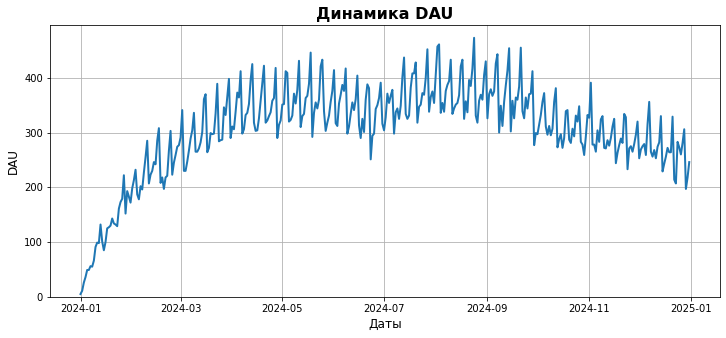

In [10]:
# Построим визуализацию DAU
plt.figure(figsize=(12, 5))

sns.lineplot(data=dau, x='event_date', y='dau', linewidth=2)

plt.title('Динамика DAU', fontsize=16, weight='bold')
plt.xlabel('Даты', fontsize=12)
plt.ylabel('DAU', fontsize=12)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

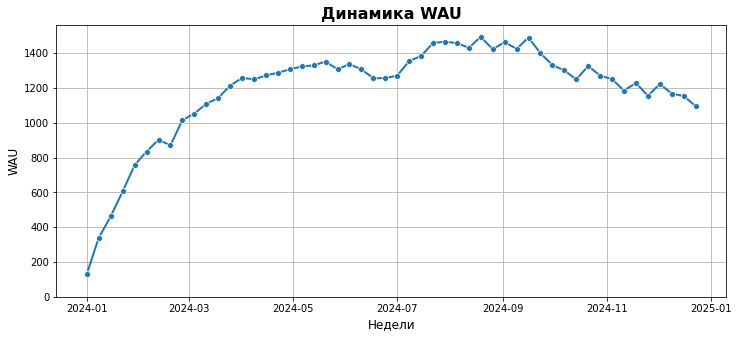

In [11]:
# Построим визуализацию WAU
plt.figure(figsize=(12, 5))
sns.lineplot(data=wau, x='event_week', y='wau', marker='o', linewidth=2)

plt.title('Динамика WAU', fontsize=16, weight='bold')
plt.xlabel('Недели', fontsize=12)
plt.ylabel('WAU', fontsize=12)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

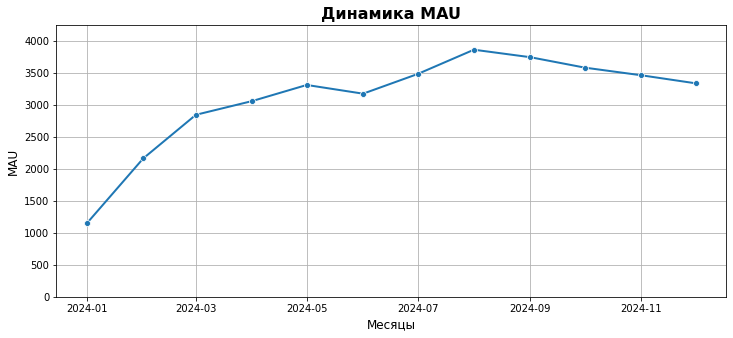

In [12]:
# Построим визуализацию MAU
plt.figure(figsize=(12, 5))
sns.lineplot(data=mau, x='event_month', y='mau', marker='o', linewidth=2)

plt.title('Динамика MAU', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('MAU', fontsize=12)
plt.ylim([0, mau['mau'].max() * 1.1])
plt.grid(True)
plt.show()

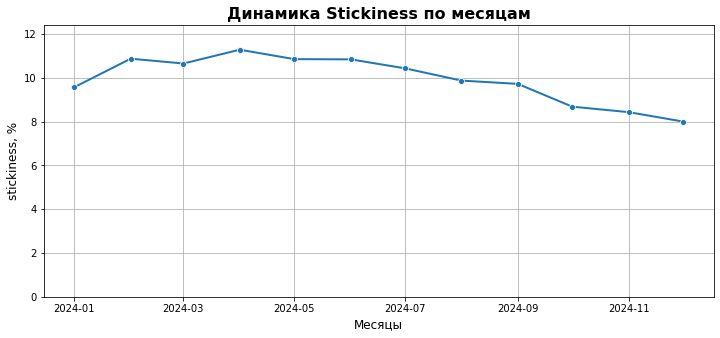

In [13]:
# Посмотрим динамику Stickiness 
plt.figure(figsize=(12, 5))

sns.lineplot(data=df_stickiness, x='event_month', y='stickiness', marker='o', linewidth=2)

plt.title('Динамика Stickiness по месяцам', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('stickiness, %', fontsize=12)
plt.ylim([0, df_stickiness['stickiness'].max() * 1.1])
plt.grid(True)
plt.show()

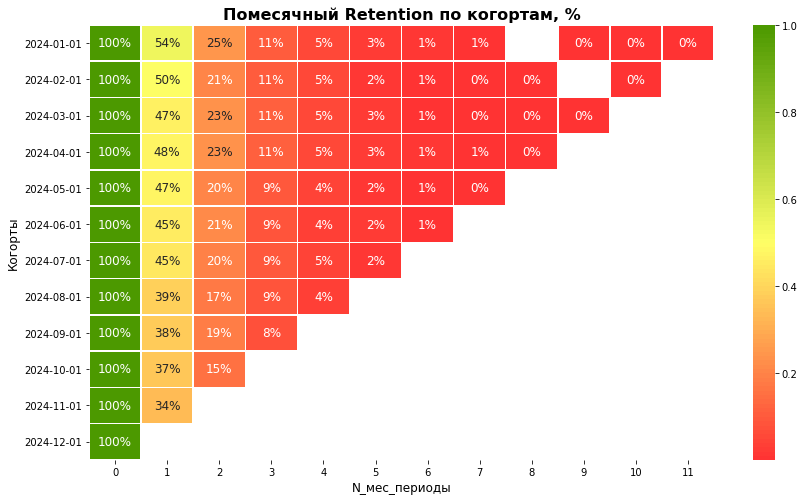

In [14]:
# Рассчитаем и визуализируем поведенческий Retention по месяцам
cmap = mcolors.LinearSegmentedColormap.from_list(
    'green_red',
    ['#FF3333', '#FFFF66', '#4C9900'],  
    N=100
)

# Создадим датасет с пользователями, которые есть и в pa_marketplace_users, и в pa_marketplace_events, т.е. имеют когорту и активны.
df_retention = pa_marketplace_events[pa_marketplace_events.user_id.isin(pa_marketplace_users.user_id)].copy()
df_retention['first_event_month'] = df_retention.groupby('user_id')['event_month'].transform('min')

df_retention['n_month'] = (df_retention['event_month'].dt.to_period('M').astype('int') 
                            - df_retention['first_event_month'].dt.to_period('M').astype('int'))


df_retention_pivot = pd.pivot_table(df_retention,
                              index='first_event_month',
                              values='user_id',
                              columns='n_month',
                              aggfunc='nunique')
df_retention_pivot = df_retention_pivot.div(df_retention_pivot[0], axis=0)

df_retention_pivot.index = pd.to_datetime(df_retention_pivot.index).strftime('%Y-%m-%d')

plt.figure(figsize=(14, 8))

sns.heatmap(df_retention_pivot,
            cmap=cmap,
            annot=True,
            fmt='.0%',
            linewidth=0.5,
            annot_kws={'size': 12})

plt.title('Помесячный Retention по когортам, %', fontsize=16, weight='bold')
plt.xlabel('N_мес_периоды', fontsize=12)
plt.ylabel('Когорты', fontsize=12)
plt.show()

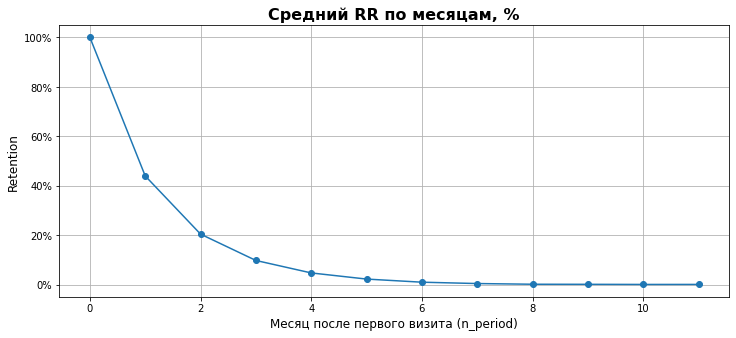

In [15]:
# Визуализируем среднее удержание
plt.figure(figsize=(12, 5))

df_retention_pivot.mean().plot(marker='o')

plt.title('Средний RR по месяцам, %', fontsize=16, weight='bold')
plt.xlabel('Месяц после первого визита (n_period)', fontsize=12)
plt.ylabel('Retention', fontsize=12)
# Форматируем ось Y в процентах
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.grid(True)
plt.show()

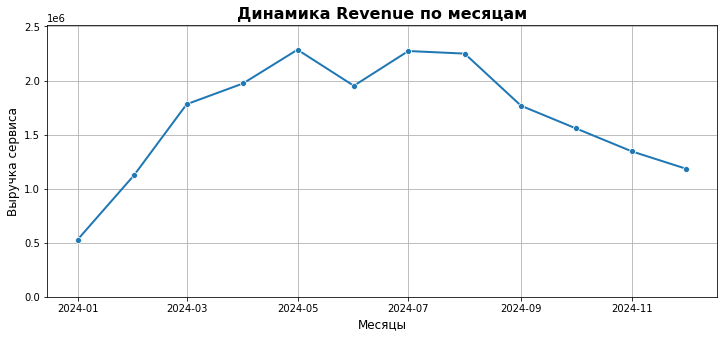

In [16]:
# Посмотрим динамику Revenue
df_revenue = pa_marketplace_orders[pa_marketplace_orders.user_id.isin(pa_marketplace_events.user_id)] \
                                                                .groupby('order_month')['total_price'].sum().reset_index()
df_revenue.rename(columns={'total_price': 'month_gmv'}, inplace=True)

# Посчитаем выручку маркетплейса как GMV * 0.05
df_revenue['month_revenue'] = round(df_revenue['month_gmv'] * 0.05, 2)

plt.figure(figsize=(12, 5))

sns.lineplot(data=df_revenue, x='order_month', y='month_revenue', marker='o', linewidth=2)

plt.title('Динамика Revenue по месяцам', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('Выручка сервиса', fontsize=12)
plt.ylim([0, df_revenue['month_revenue'].max() * 1.1])
plt.grid(True)
plt.show()

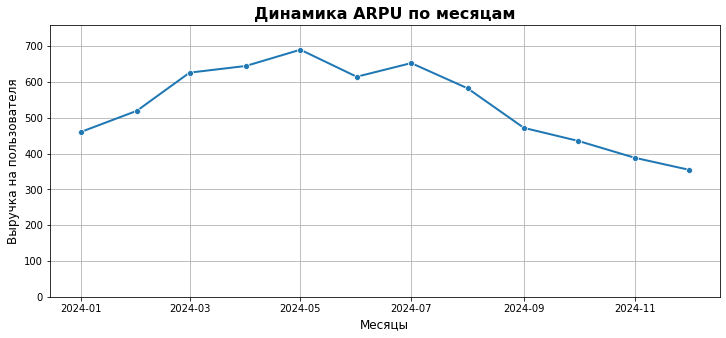

In [17]:
# Посмотрим динамику ARPU
df_active_usrs = mau.copy()
df_active_usrs.rename(columns={'mau': 'month_usr_cnt'}, inplace=True)

df_arpu = df_revenue.merge(df_active_usrs, left_on='order_month', right_on='event_month', how='inner')
df_arpu['arpu'] = round(df_arpu['month_revenue'] / df_arpu['month_usr_cnt'], 2)

plt.figure(figsize=(12, 5))

sns.lineplot(data=df_arpu, x='event_month', y='arpu', marker='o', linewidth=2)


plt.title('Динамика ARPU по месяцам', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('Выручка на пользователя', fontsize=12)
plt.ylim([0, df_arpu['arpu'].max() * 1.1])
plt.grid(True)
plt.show()

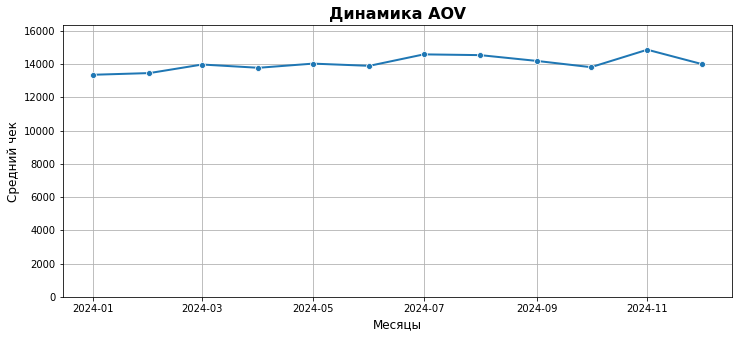

In [18]:
# Посмотрим динамику AOV
df_orders = pa_marketplace_orders[pa_marketplace_orders.user_id.isin(pa_marketplace_events.user_id)] \
            .groupby('order_month')['order_id'].nunique().reset_index().rename(columns={'order_id': 'n_orders'})

df_aov = df_orders.merge(df_revenue, on='order_month', how='inner')
df_aov['aov'] = round(df_aov.month_gmv / df_aov.n_orders, 2)

plt.figure(figsize=(12, 5))

sns.lineplot(data=df_aov, x='order_month', y='aov', marker='o', linewidth=2)

plt.title('Динамика AOV', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('Средний чек', fontsize=12)
plt.ylim([0, df_aov['aov'].max() * 1.1])
plt.grid(True)
plt.show()

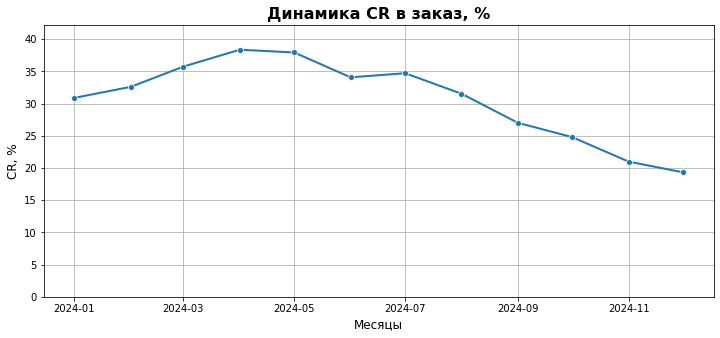

In [19]:
# Посмотрим динамику CR в заказ
df_buyers = pa_marketplace_orders[pa_marketplace_orders.user_id.isin(pa_marketplace_events.user_id)] \
        .groupby('order_month', as_index=False)['user_id'].nunique().rename(columns={'user_id': 'n_buyers'})

df_cr = df_active_usrs.merge(df_buyers, left_on='event_month', right_on='order_month', how='inner')
df_cr['CR_to_ord'] = round(100 * df_cr.n_buyers / df_cr.month_usr_cnt, 2)

plt.figure(figsize=(12, 5))

sns.lineplot(data=df_cr, x='event_month', y='CR_to_ord', marker='o', linewidth=2)

plt.title('Динамика CR в заказ, %', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('CR, %', fontsize=12)
plt.ylim([0, df_cr['CR_to_ord'].max() * 1.1])
plt.grid(True)
plt.show()

In [20]:
# CTR из просмотра карточки товара в клик по товару
df_ctr = pa_marketplace_events.query('event_type == "product_view" or event_type == "product_click"') \
        .groupby(['event_month', 'event_type']).agg(event_cnt=('user_id', 'nunique')).reset_index()

df_ctr_pivot = pd.pivot(df_ctr, 
                       index='event_month',
                       values='event_cnt',
                       columns='event_type')
df_ctr_pivot['ctr'] = round(100 * df_ctr_pivot['product_click'] / df_ctr_pivot['product_view'], 2)
df_ctr_pivot

event_type   product_click  product_view    ctr
event_month                                    
2024-01-01            1077          1086  99.17
2024-02-01            2019          2048  98.58
2024-03-01            2624          2662  98.57
2024-04-01            2840          2870  98.95
2024-05-01            3066          3107  98.68
2024-06-01            2901          2943  98.57
2024-07-01            3235          3281  98.60
2024-08-01            3598          3644  98.74
2024-09-01            3488          3554  98.14
2024-10-01            3345          3412  98.04
2024-11-01            3232          3315  97.50
2024-12-01            3123          3214  97.17

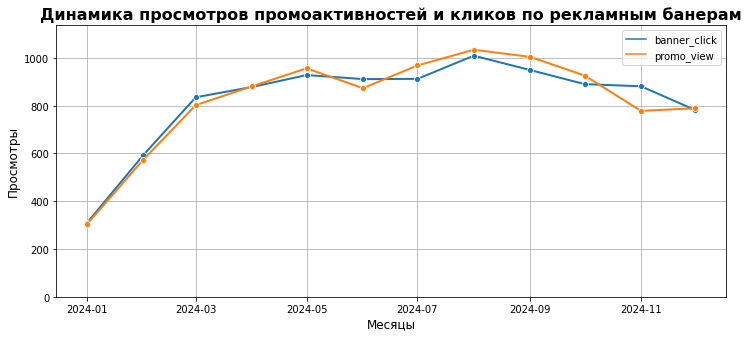

In [21]:
promo_df = pa_marketplace_events[pa_marketplace_events.event_type.isin(['promo_view', 'banner_click'])].groupby(['event_type', 'event_month']).agg(usrs=('user_id', 'nunique')).reset_index()

plt.figure(figsize=(12, 5))

sns.lineplot(data=promo_df, x='event_month', y='usrs', hue='event_type', marker='o', linewidth=2)


plt.title('Динамика просмотров промоактивностей и кликов по рекламным банерам', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('Просмотры', fontsize=12)
plt.legend()
plt.ylim([0, promo_df['usrs'].max() * 1.1])
plt.grid(True)
plt.show()

### 3. Оценка метрик монетизации и юнит-экономики

Выполните анализ монетизации. Определите, сколько зарабатывает продукт и сколько тратит на привлечение.

Важны как агрегированные метрики (ARPU, AOV), так и показатели эффективности (CAC, ROI, Payback Period).

Сформулируйте первые выводы по результатам анализа метрик. Сделайте это в формате записки для заказчика. Изложите все основные результаты так, чтобы прослеживалась связь между мыслями. Не пишите много — заказчик не будет читать записку полностью, а просто просмотрит.

Напишите выводы в конце блока, чтобы заказчик мог быстро ознакомиться с основными результатами.

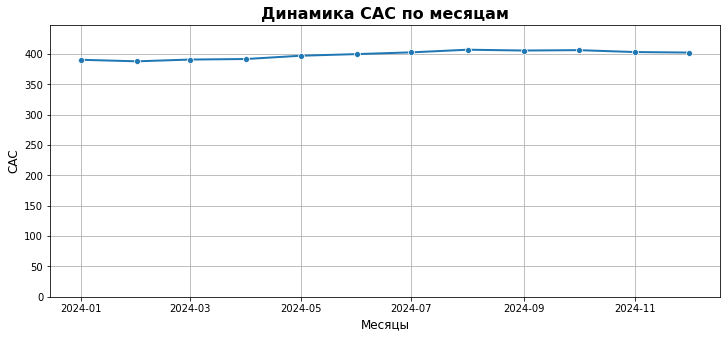

In [22]:
# Посмотрим динамику общего CAC по месяцам
df_CAC = pa_marketplace_users.merge(pa_marketplace_campaign_costs, 
                            left_on=['cohort_month', 'acq_channel'], 
                            right_on=['spend_month', 'acq_channel'], how='right')


df_CAC_grouped = df_CAC.groupby('cohort_month', as_index=False).agg(user_cnt=('user_id', 'nunique'),
                                                                   month_budget=('budget', 'unique'))

# Посчитаем совокупный месячный бюджет по всем источникам трафика
df_CAC_grouped['month_budget'] = df_CAC_grouped['month_budget'].apply(lambda x: sum(x))

# Посчитаем общий САС
df_CAC_grouped['cac'] = round(df_CAC_grouped['month_budget'] / df_CAC_grouped['user_cnt'], 2)

# Визуализируем САС по месяцам
plt.figure(figsize=(12, 5))

sns.lineplot(data=df_CAC_grouped, x='cohort_month', y='cac', marker='o', linewidth=2)

plt.title('Динамика CAC по месяцам', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('CAC', fontsize=12)
plt.ylim([0, df_CAC_grouped['cac'].max() * 1.1])
plt.grid(True)
plt.show()

In [23]:
# Посчитаем накопленный LTV по когортам
# Соединим pa_marketplace_orders и pa_marketplace_users
df_orders_users = pa_marketplace_orders.merge(pa_marketplace_users[['user_id', 'cohort_month']], on='user_id', how='inner')

# Посчитаем месяцы жизни когорт
df_orders_users['n_month'] = (df_orders_users['order_month'].dt.to_period('M').astype('int') - 
                              df_orders_users['cohort_month'].dt.to_period('M').astype('int'))
 
# Доход по когортам и месяцам жизни
revenue_by_cohort = df_orders_users.groupby(['cohort_month', 'n_month']).agg(gmv_cohort=('total_price', 'sum')).reset_index() 

# Размер когорт
cohort_size = pa_marketplace_users.groupby('cohort_month').agg(cohort_usr_cnt=('user_id', 'nunique')).reset_index()

# Добавим к df_orders_users размер когорт
revenue_by_cohort = revenue_by_cohort.merge(cohort_size, on='cohort_month', how='inner')

# Отсортируем revenue_by_cohort для корректной работы cumsum
revenue_by_cohort.sort_values(by=['cohort_month', 'n_month'], inplace=True)

# Посчитаем накопленную GMV в динамике на уровне когорт
revenue_by_cohort['gmv_cumsum'] = revenue_by_cohort.groupby('cohort_month')['gmv_cohort'].cumsum()

# Посчитаем накопленный LTV на каждого пользователя когорт, 
revenue_by_cohort['ltv'] = revenue_by_cohort['gmv_cumsum'] * 0.05 / revenue_by_cohort['cohort_usr_cnt']

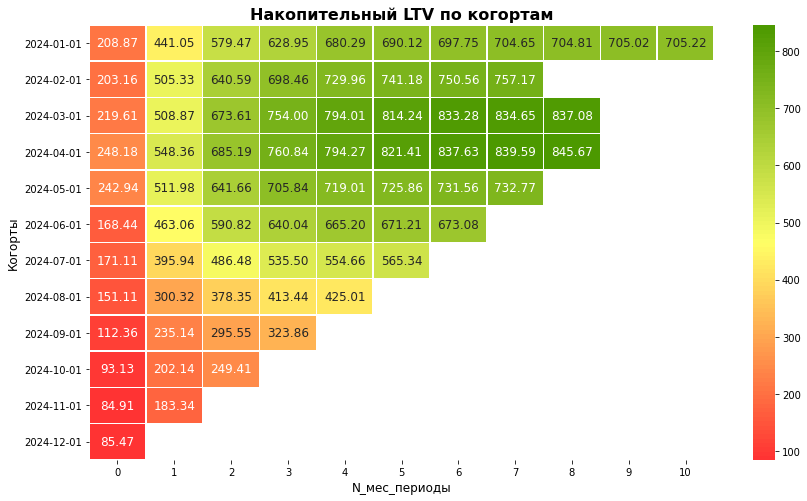

In [24]:
# Построим визуализацию для накопительного LTV по месячным когортам
ltv_by_cohort_pivot = pd.pivot(revenue_by_cohort,
                              index='cohort_month',
                              values='ltv',
                              columns='n_month')


ltv_by_cohort_pivot.index = pd.to_datetime(ltv_by_cohort_pivot.index).strftime('%Y-%m-%d')

plt.figure(figsize=(14, 8))

sns.heatmap(ltv_by_cohort_pivot,
            cmap=cmap,
            annot=True,
            fmt='.2f',
            linewidth=0.5,
            annot_kws={'size': 12})

plt.title('Накопительный LTV по когортам', fontsize=16, weight='bold')
plt.xlabel('N_мес_периоды', fontsize=12)
plt.ylabel('Когорты', fontsize=12)
plt.show()

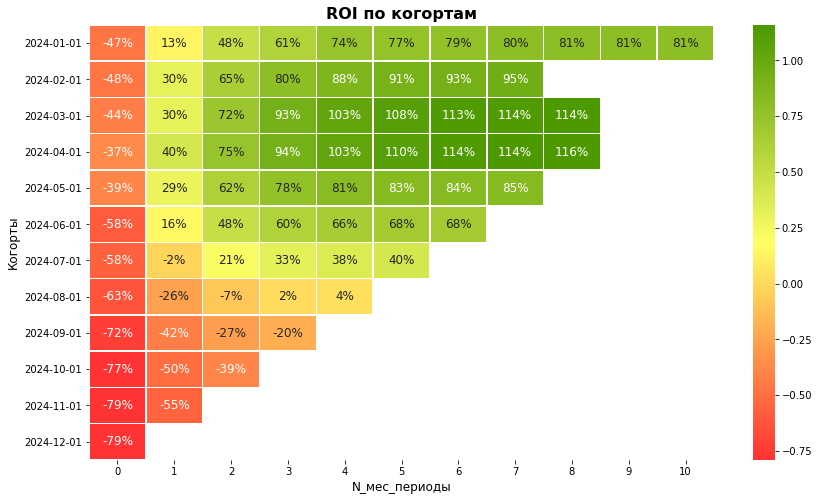

In [25]:
# Посчитаем накопленный ROI по месячным когортам
roi_by_cohort = revenue_by_cohort[['cohort_month', 'n_month', 'ltv']].merge(df_CAC_grouped[['cohort_month', 'cac']], on='cohort_month', how='inner')
roi_by_cohort['roi'] = (roi_by_cohort.ltv - roi_by_cohort.cac) / roi_by_cohort.cac

# Построим визуализацию для ROI по месячным когортам
roi_by_cohort_pivot = pd.pivot(roi_by_cohort,
                              index='cohort_month',
                              values='roi',
                              columns='n_month')


roi_by_cohort_pivot.index = pd.to_datetime(roi_by_cohort_pivot.index).strftime('%Y-%m-%d')

plt.figure(figsize=(14, 8))

sns.heatmap(roi_by_cohort_pivot,
            cmap=cmap,
            annot=True,
            fmt='.0%',
            linewidth=0.5,
            annot_kws={'size': 12})

plt.title('ROI по когортам', fontsize=16, weight='bold')
plt.xlabel('N_мес_периоды', fontsize=12)
plt.ylabel('Когорты', fontsize=12)
plt.show()

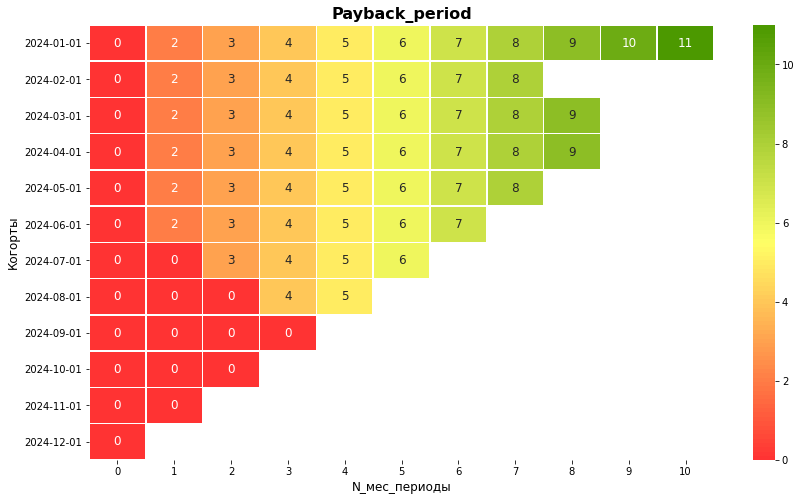

In [26]:
# Посчитаем и визуализируем Payback Period по когортам
roi_by_cohort['Payback_period'] = roi_by_cohort.apply(lambda row: row['n_month'] + 1 if row['ltv'] >= row['cac'] else 0, axis=1)
payback_period_pivot = pd.pivot(roi_by_cohort,
                               index='cohort_month',
                               values='Payback_period',
                               columns='n_month')
#payback_period_pivot
#payback_period_pivot = payback_period_pivot.apply(lambda row: row.min() if row['ltv'] >= row['cac'] else 0, axis=0)

payback_period_pivot.index = pd.to_datetime(payback_period_pivot.index).strftime('%Y-%m-%d')

plt.figure(figsize=(14, 8))

sns.heatmap(payback_period_pivot,
            cmap=cmap,
            annot=True,
            fmt='.0f',
            linewidth=0.5,
            annot_kws={'size': 12})

plt.title('Payback_period', fontsize=16, weight='bold')
plt.xlabel('N_мес_периоды', fontsize=12)
plt.ylabel('Когорты', fontsize=12)
plt.show()

## Выводы по этапам 2 и 3


Представьте ключевые выводы в текстовом виде здесь или приложите ссылку на документ с презентацией.

Не забудьте предоставить доступ на просмотр и комментирование документа.

**Обзор основных метрик продукта:**
- Динамика активных пользователей в разрезе дней, недель, месяцев демонстрирует восходящий тренд аудитории продукта с начала 2024 года к августу, к концу года откатившись на 14% от летнего пика.  
- Динамика заинтересованности платформой Stickiness с апреля 2024 имеет нисходящий тренд вплоть до конца 2024г, снизившись на 27%. 
- Помесячный Retention показывает, что продукт изначально довольно быстро теряет пользователей, которые от месяца к месяцу сокращаются вдвое, пока к 7-му месяцу жизни когорты не останется 1% от изначально привлеченных. При этом когорты августа и позднее демнстрируют ухудшение RR на 2 и 3 мес жизни.
- Динамика комиссионного Revenue платформы с начала 2024 года растет до мая, стагнирует и с августа снижается до конца года, упав на 47% от пика. 
- Метрика ARPU демонстрирует схожую динамику с Revenue, опустившись с мая 2025 года к концу года на 48%.
- Средний чек покупок AOV стабилен весь год, колеблясь около 14000 +\- 5%.
- Метрика конверсии в покупку показывает схожую динамику с ARPU и Revenue, опустившись с мая 2025 года к концу года также на 48%.
- Весь год на платформе росла активность промоакций на платформе вплоть до августа 2024, далее опускается на 20% к концу года, при это отклик на рекламные предложения со стороны пользователей высок и следует за трендом промоактивностей продукта.

**Оценка метрик монетизации и юнит-экономики:**
- Продукт тратит стабильно весь год около 400 у.е в месяц на каждого привлеченного пользователя.
- Когорты Накопительный LTV, ROI растут начала год и по апрель, а более поздние от месяца к месяцу все менее прибыльны и рентабельны. При этом все когорты к 6-му месяцу почти полностью прекращают приносить прибыль.
- Окупаемость проекта удлиняется с июльских когорт, каждый месяц: в то время как когорты до июля окупали затраты на привлечение за 2 месяца, сентябрьские не окупают себя и за 4 месяца.

**Выводы и предположения:**
- С лета 2024 изменилась стратегия привлечения новых пользователей, что привело к притоку низкокачественного трафика.
- Сервис привлекает в основном одноразовых покупателей, пришедших за акцией.
- В мае произошло изменение продукта/UX, ухудшившее путь к покупке.
- Проблемы с техническим качеством на определенных платформах (iOS/Android/Web) снижают конверсию.
- Проблемы с первым опытом.
- Определенные категории товаров просели в продажах.

## 4. Поиск инсайтов, точек роста и сегментация


После того как вы провели верхнеуровневую оценку данных, самое время переходить от общей картины к точечным наблюдениям. Посмотрите вглубь данных: по каналам,
сегментам пользователей, категориям товаров, регионам, типам устройств. Ищите
закономерности, различия, аномалии.

Цель — сформировать обоснованные гипотезы:

* какие сегменты работают лучше остальных
* какие сегменты работают хуже остальных
* на каких этапах воронки теряются пользователи
* какие группы можно или нужно масштабировать
* куда стоит инвестировать больше внимания или ресурсов

По итогам анализа также:

* сформулируйте в виде аналитической записки выводы
* сформулируйте несколько гипотез, которые помогут развить продукт. Например: «Если предлагать клиентам на iOS персонализированные скидки, то они станут чаще конвертировать в продукт». При формулировании гипотез опишите, на что вы опираетесь при её формировании. Например, на динамику метрики или на взаимосвязь метрик.

Напишите выводы в конце блока, чтобы заказчик мог быстро ознакомиться с основными результатами.
Отправьте работу на проверку ревьюеру. Ревьюер будет проверять корректность выводов и гипотез, а не сам код расчета, поэтому проверьте, что у вас есть выводы по каждому из блоков в предназначенном для этого месте.
После завершения ревью вы получите от ревьюера новые вводные и задачу от бизнеса.


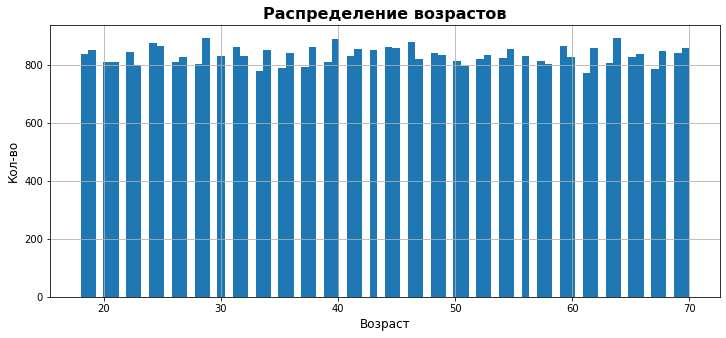

In [27]:
# Посмотрим на распределение возрастов
plt.figure(figsize=(12, 5))
plt.hist(pa_marketplace_users['age'], bins=80)

plt.title('Распределение возрастов', fontsize=16, weight='bold')
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Кол-во', fontsize=12)
plt.grid(True)
plt.show()

In [28]:
# Напишем функции для сегментации и визуализации в динамике различных метрик
df_event_users = pa_marketplace_events.merge(pa_marketplace_users, on='user_id', how='inner')
df_orders_users = pa_marketplace_orders.merge(pa_marketplace_users, on='user_id', how='inner')

# Функция для сегментации и визуализации MAU
def mau_segment(df_base, period, segment):
    
    mau_segment = df_base.groupby([period, segment]).agg(usr_cnt=('user_id', 'nunique')).reset_index()
    
    plt.figure(figsize=(12, 5))

    sns.lineplot(data=mau_segment, x=period, y='usr_cnt', hue=segment, marker='o', linewidth=2)

    plt.ylim(bottom=0)
    plt.title(f'MAU в разрезе {segment}', fontsize=16, weight='bold')
    plt.xlabel('Месяцы', fontsize=12)
    plt.ylabel('MAU', fontsize=12)
    plt.grid(True)
    plt.show()


# Функция для сегментации и визуализации Stickness
def stickness_segment(df_base, period, segment):
    
    dau_segment = df_base.groupby(['event_date', segment]).agg(dau=('user_id', 'nunique')).reset_index()
    mau_segment = df_base.groupby([period, segment]).agg(usr_cnt=('user_id', 'nunique')).reset_index()

    # Посчитаем средний dau по месяцам
    dau_segment['event_month'] = dau_segment.event_date.dt.to_period('M').dt.to_timestamp()
    dau_avg_m_segment = round(dau_segment.groupby(['event_month', segment]).agg(dau_avg=('dau', 'mean')).reset_index())

    # Объединим dau_avg_m и mau датафреймы, и посчитаем stickiness
    df_stickiness_segment = pd.merge(dau_avg_m_segment, mau_segment, 
                            left_on=['event_month', segment], 
                            right_on=[period, segment], 
                            how='inner')
    df_stickiness_segment['stickiness'] = round(df_stickiness_segment.dau_avg / df_stickiness_segment.usr_cnt * 100, 2)

    plt.figure(figsize=(12, 5))

    sns.lineplot(data=df_stickiness_segment, x=period, y='stickiness', hue=segment, marker='o', linewidth=2)

    plt.ylim(bottom=0)
    plt.title(f'Stickiness в разрезе {segment}', fontsize=16, weight='bold')
    plt.xlabel('Месяцы', fontsize=12)
    plt.ylabel('stickiness, %', fontsize=12)
    plt.grid(True)
    plt.show()


# Функция для сегментации и визуализации CR в покупку    
def cr_to_purchase_segment(segment):

    df_orders_users_ev = pd.merge(df_orders_users, df_event_users[['user_id', 'os', 'device']], on='user_id', how='inner')
    
    df_buyers_segment = df_orders_users_ev.groupby(['order_month', segment], as_index=False)['user_id'].nunique() \
                                                                            .rename(columns={'user_id': 'n_buyers'})
    df_active_usrs_segment = df_event_users.groupby(['event_month', segment], as_index=False)['user_id'].nunique() \
                                                                            .rename(columns={'user_id': 'month_usr_cnt'})
    
    df_cr_segment = df_active_usrs_segment.merge(df_buyers_segment, 
                                                 left_on=['event_month', segment], 
                                                 right_on=['order_month', segment], 
                                                 how='inner')
    df_cr_segment['CR_to_ord'] = round(100 * df_cr_segment.n_buyers / df_cr_segment.month_usr_cnt, 2)

    plt.figure(figsize=(12, 5))

    sns.lineplot(data=df_cr_segment, x='event_month', y='CR_to_ord', hue=segment, marker='o', linewidth=2)

    plt.title(f'Динамика CR в заказ в разрезе {segment}, %', fontsize=16, weight='bold')
    plt.xlabel('Месяцы', fontsize=12)
    plt.ylabel('CR, %', fontsize=12)
    plt.ylim([0, df_cr_segment['CR_to_ord'].max() * 1.1])
    plt.grid(True)
    plt.show() 
 

# Функция для сегментации и визуализации динамики AOV
def aov_segments(segment):
    
    df_aov = (df_orders_users
          .groupby(['order_month', segment])
          .agg(n_orders=('order_id', 'nunique'),
               month_gmv=('total_price', 'sum'))
          .reset_index()
          .assign(aov=lambda x: round(x['month_gmv'] / x['n_orders'], 2)))

    plt.figure(figsize=(12, 5))

    sns.lineplot(data=df_aov, x='order_month', y='aov', hue=segment, marker='o', linewidth=2)

    plt.title(f'Динамика AOV в разрезе {segment}', fontsize=16, weight='bold')
    plt.xlabel('Месяцы', fontsize=12)
    plt.ylabel('Средний чек', fontsize=12)
    plt.ylim([0, df_aov['aov'].max() * 1.1])
    plt.grid(True)
    plt.show()
    

# Функция для сегментации и визуализации классической и пошаговой воронок    
def funel_with_segments(segment):
    
    # Шаги воронки
    funel_steps = ['page_view', 'product_view', 'add_to_cart', 'checkout_start', 'checkout_complete']
    
    for i in df_event_users[segment].unique():
        

        funel_df = df_event_users[df_event_users[segment] == i].groupby('event_type').agg(usr_cnt=('user_id', 'nunique')).reindex(funel_steps).reset_index()

        # Классическая конверсия на разных этапах воронки
        funel_df['classic_CR'] = funel_df.usr_cnt.div(funel_df.usr_cnt[0]).round(3) * 100

        # Step-by-step конверсия на разных этапах воронки
        funel_df['sbs_CR'] = funel_df.usr_cnt.div(funel_df.usr_cnt.shift(1)).round(3) * 100

        # Построим диаграммы для обоих воронок для различных сегментов пользователей

        fig, axes = plt.subplots(2, 1, figsize=(12, 6))

        # Диаграмма Классическая воронка: конверсия по этапам
        axes[0].bar(funel_df.event_type, funel_df.classic_CR)
        axes[0].set_title(f'Классическая воронка {i}: конверсия по этапам', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Типы событий', fontsize=12)
        axes[0].set_ylabel('CR, %', fontsize=12)
        axes[0].set_yticks(range(0, 101, 10))
        axes[0].grid(axis='y', alpha=0.5)
        axes[0].tick_params(axis='both', labelsize=11)

        for x,y in zip(funel_df.event_type,funel_df.classic_CR):

            label = "{:.2f}%".format(y)

            axes[0].annotate(label,
                             (x,y), 
                             textcoords="offset points", 
                             color='white',    
                             xytext=(0,-20),
                             ha='center')

        # Диаграмма Step-by-step воронка: конверсия от предыдущего этапа
        axes[1].bar(funel_df.event_type, funel_df.sbs_CR)
        axes[1].set_title(f'Step-by-step воронка: конверсия от предыдущего этапа {i}', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Типы событий', fontsize=12)
        axes[1].set_ylabel('CR, %', fontsize=12)
        axes[1].set_ylim(top=100)
        axes[1].set_yticks(range(0, 101, 10))
        axes[1].grid(axis='y', alpha=0.5)
        axes[1].tick_params(axis='both', labelsize=11)

        for x,y in zip(funel_df.event_type, funel_df.sbs_CR):

            label = "{:.2f}%".format(y)

            axes[1].annotate(label,
                             (x,y), 
                             textcoords="offset points", 
                             color='white',    
                             xytext=(0,-20),
                             ha='center')

        plt.tight_layout()
        plt.show()    

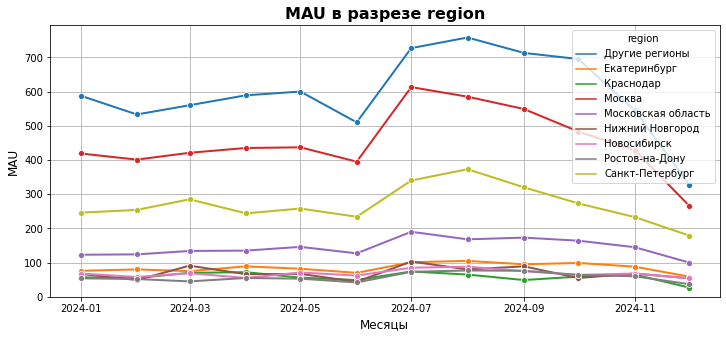

In [29]:
# Динамика MAU в разрезе регионов
mau_segment(df_event_users, 'cohort_month', 'region')

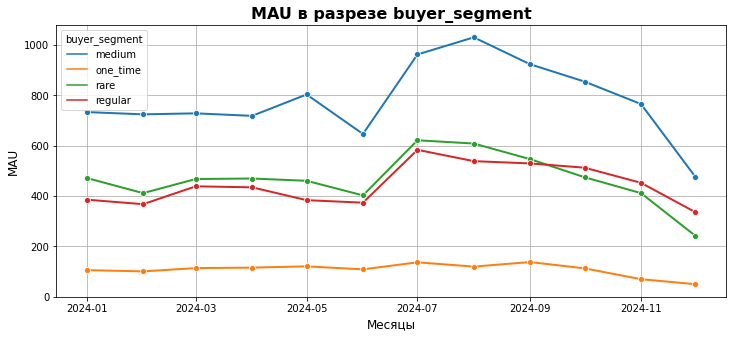

In [30]:
# Динамика MAU в разрезе покупательских сегментов
mau_segment(df_event_users, 'cohort_month', 'buyer_segment')

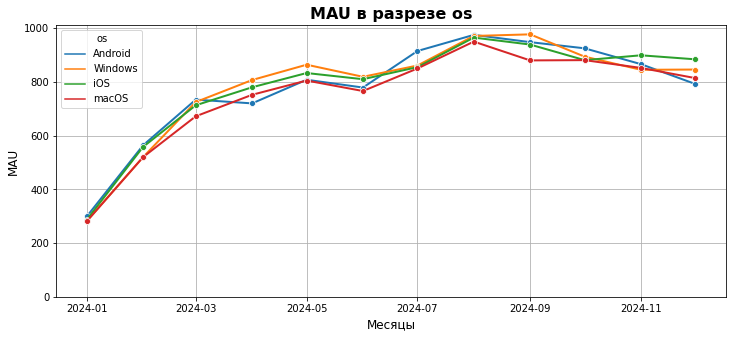

In [31]:
# Динамика MAU в разрезе os
mau_segment(pa_marketplace_events, 'event_month', 'os')

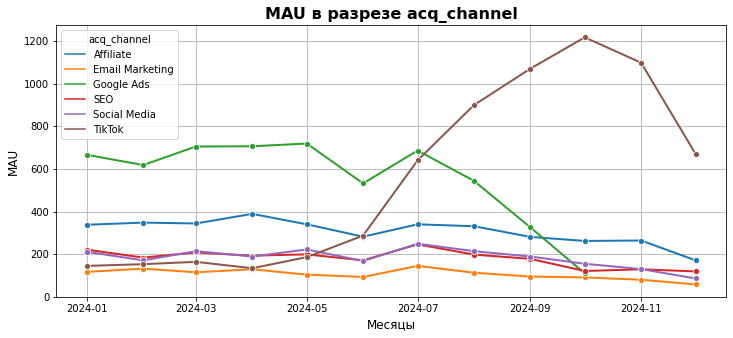

In [32]:
# MAU в разрезе источников привлечения
mau_segment(df_event_users, 'cohort_month', 'acq_channel')

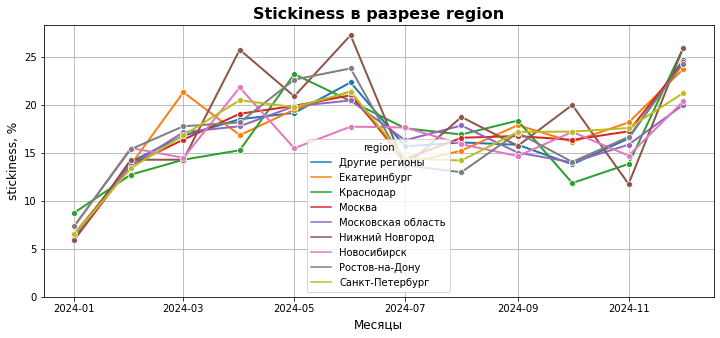

In [33]:
# Построим визуализацию Stickness в разрезе region
stickness_segment(df_event_users, 'cohort_month', 'region')

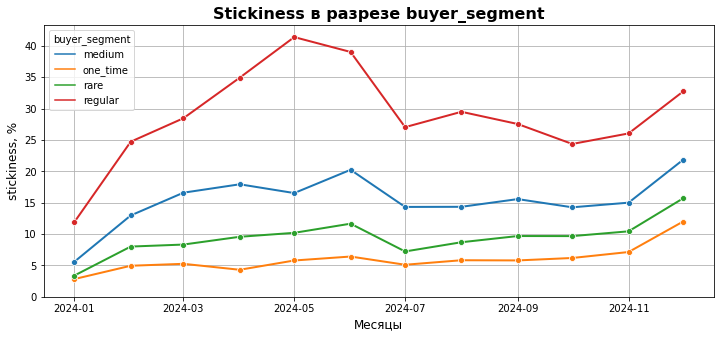

In [34]:
# Построим визуализацию Stickness в разрезе buyer_segment
stickness_segment(df_event_users, 'cohort_month', 'buyer_segment')

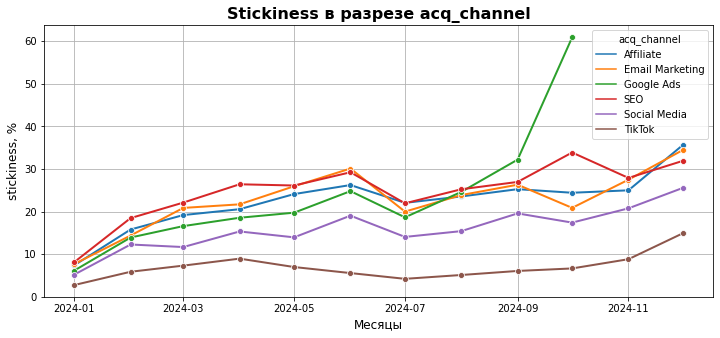

In [35]:
# Построим визуализацию Stickness в разрезе источников привлечения
stickness_segment(df_event_users, 'cohort_month', 'acq_channel')

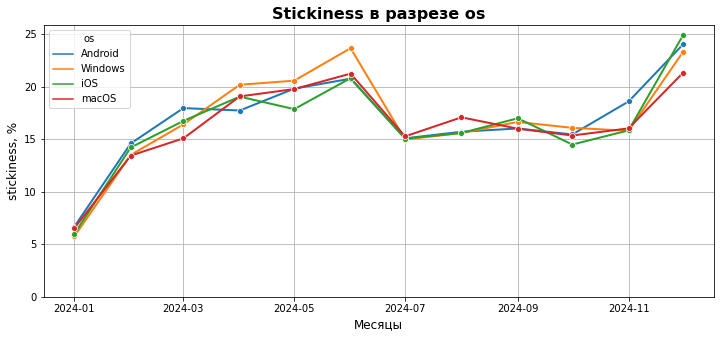

In [36]:
# Построим визуализацию Stickness в разрезе buyer_segment
stickness_segment(df_event_users, 'cohort_month', 'os')

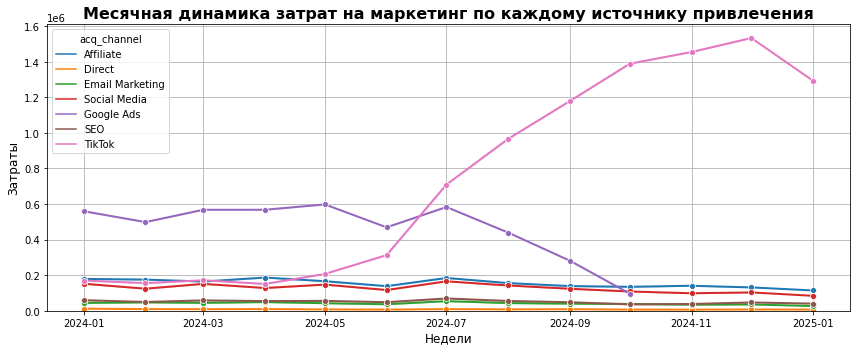

In [37]:
# Построим визуализацию месячной динамики затрат на маркетинг по каждому источнику привлечения
plt.figure(figsize=(12, 5))

sns.lineplot(data=df_CAC, x='spend_month', y='budget', hue='acq_channel', linewidth=2, marker='o')

plt.ylim(bottom=0)
plt.title('Месячная динамика затрат на маркетинг по каждому источнику привлечения', fontsize=16, weight='bold')
plt.xlabel('Недели', fontsize=12)
plt.ylabel('Затраты', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

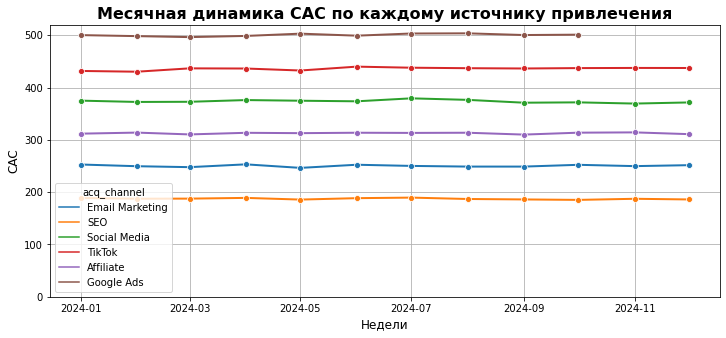

In [38]:
# Построим визуализацию месячной динамики CAC по каналам привлечения
df_CAC_ch = df_CAC.dropna().groupby(['spend_month', 'budget', 'acq_channel']).user_id.nunique().reset_index()

df_CAC_ch['cac'] = df_CAC_ch['budget'].div(df_CAC_ch.user_id)

# Построим визуализацию недельной динамики среднего CAC по каждому источнику привлечения
plt.figure(figsize=(12, 5))

sns.lineplot(data=df_CAC_ch, x='spend_month', y='cac', hue='acq_channel', linewidth=2, marker='o')

plt.title('Месячная динамика CAC по каждому источнику привлечения', fontsize=16, weight='bold')
plt.xlabel('Недели', fontsize=12)
plt.ylabel('CAC', fontsize=12)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

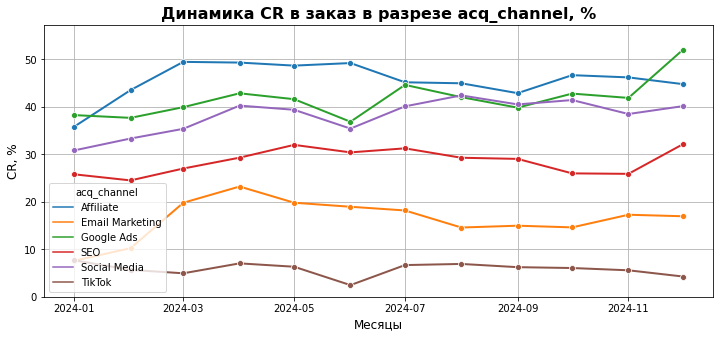

In [39]:
# Посмотрим динамику CR в заказ в разрезе источников привлечения
cr_to_purchase_segment('acq_channel')

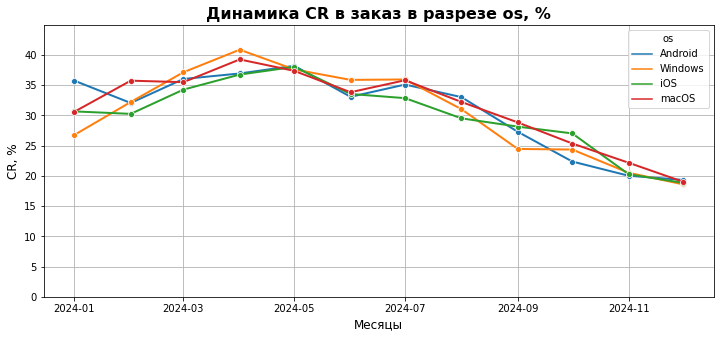

In [40]:
# Посмотрим динамику CR в заказ в разрезе os
cr_to_purchase_segment('os')

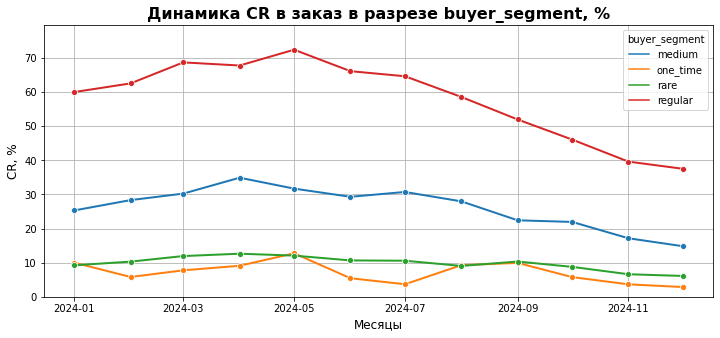

In [41]:
# Посмотрим динамику CR в заказ в разрезе os
cr_to_purchase_segment('buyer_segment')

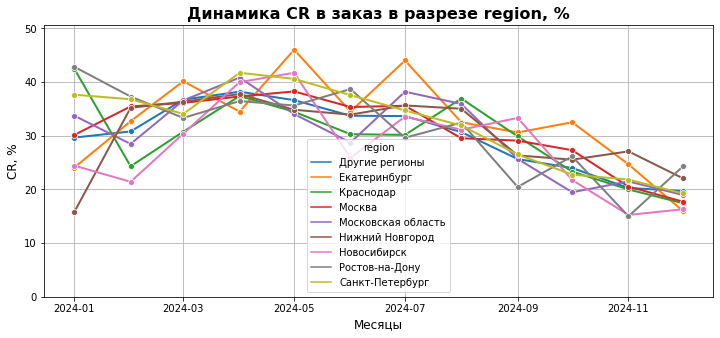

In [42]:
# Посмотрим динамику CR в заказ в разрезе os
cr_to_purchase_segment('region')

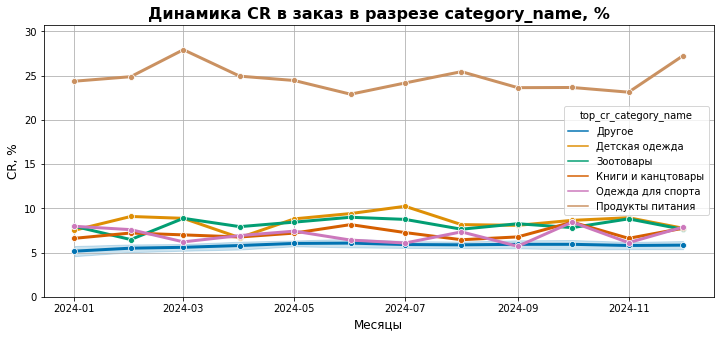

In [43]:
# Посмотрим динамику CR в заказ в разрезе категорий товаров
df_buyers_cat = df_orders_users.groupby(['order_month', 'category_name'], as_index=False)['user_id'].nunique() \
                                                                            .rename(columns={'user_id': 'n_buyers_ch'})
df_active_usrs_cat = df_orders_users.groupby('order_month', as_index=False)['user_id'].nunique() \
                                                                            .rename(columns={'user_id': 'n_buyers'})
    
df_cr_cat = df_active_usrs_cat.merge(df_buyers_cat, 
                                     on='order_month',  
                                     how='inner')

df_cr_cat['CR_to_ord'] = round(100 * df_cr_cat.n_buyers_ch / df_cr_cat.n_buyers, 2)

# Выберем максимальные по CR категории товаров
max_cr_cats = df_cr_cat.groupby('category_name').CR_to_ord.median().sort_values(ascending=False).iloc[:5].index.to_list()

df_cr_cat['top_cr_category_name'] = df_cr_cat['category_name'].apply(lambda x: x if x in max_cr_cats else "Другое")

plt.figure(figsize=(12, 5))

sns.lineplot(data=df_cr_cat, 
             x='order_month', 
             y='CR_to_ord', 
             hue='top_cr_category_name', 
             marker='o', 
             linewidth=3,
             palette="colorblind")

plt.title('Динамика CR в заказ в разрезе category_name, %', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('CR, %', fontsize=12)
plt.ylim([0, df_cr_cat['CR_to_ord'].max() * 1.1])
plt.grid(True)
plt.show() 

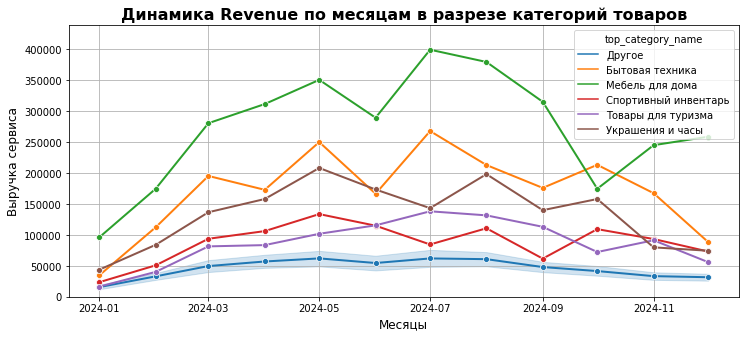

In [44]:
# Посмотрим динамику выручи в разрезе категорий товаров
df_revenue_cat = pa_marketplace_orders[pa_marketplace_orders.user_id.isin(pa_marketplace_events.user_id)] \
                                   .groupby(['order_month', 'category_name'])['total_price'].sum().reset_index()
df_revenue_cat.rename(columns={'total_price': 'month_gmv'}, inplace=True)

# Выберем максимальные по выручке категории товаров
max_val_cats = df_revenue_cat.groupby('category_name').month_gmv.median().sort_values(ascending=False).iloc[:5].index.to_list()

# Посчитаем выручку маркетплейса как GMV * 0.05
df_revenue_cat['month_revenue'] = round(df_revenue_cat['month_gmv'] * 0.05, 2)

df_revenue_cat['top_category_name'] = df_revenue_cat['category_name'].apply(lambda x: x if x in max_val_cats else "Другое")


plt.figure(figsize=(12, 5))

sns.lineplot(data=df_revenue_cat, x='order_month', y='month_revenue', hue='top_category_name', marker='o', linewidth=2)

plt.title('Динамика Revenue по месяцам в разрезе категорий товаров', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('Выручка сервиса', fontsize=12)
plt.ylim([0, df_revenue_cat['month_revenue'].max() * 1.1])
plt.grid(True)
plt.show()


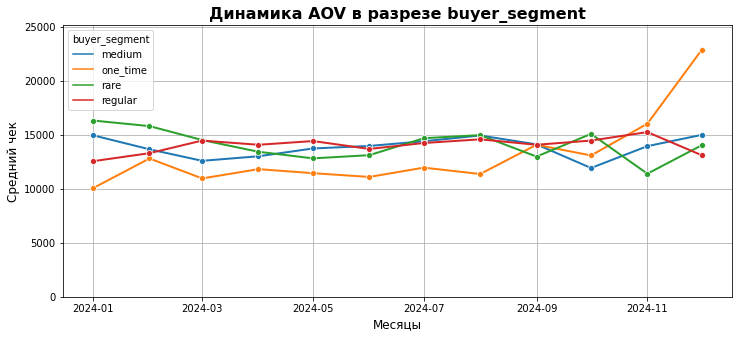

In [45]:
# Посмотрим на динамику среднего чека в разрезе buyer_segment
aov_segments('buyer_segment')

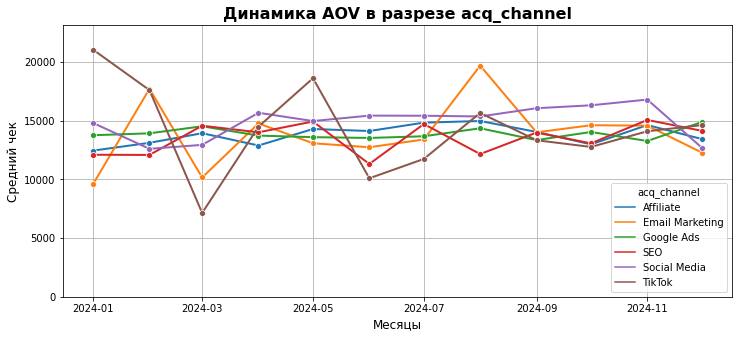

In [46]:
# Посмотрим на динамику среднего чека в разрезе acq_channel 
aov_segments('acq_channel')

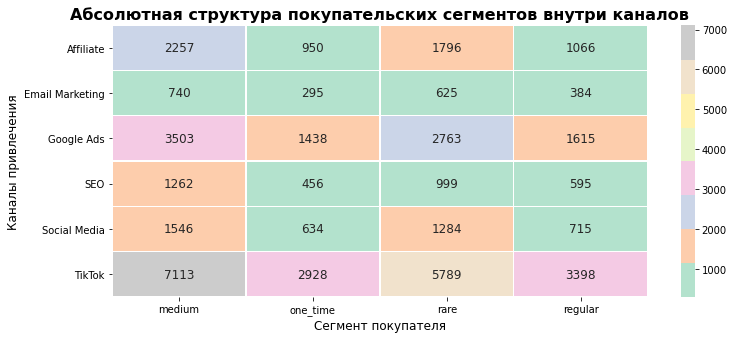

In [47]:
# Построим тепловую карту структуры покупательских сегментов внутри каналов в абсолютном выражении
pivot_usr_ch = pd.pivot_table(
    pa_marketplace_users,
    index='acq_channel',
    columns='buyer_segment',
    values='user_id',
    aggfunc='nunique',
    fill_value=0
)
pivot_usr_ch_share = pivot_usr_ch.div(pivot_usr_ch.sum(axis=1), axis=0)


plt.figure(figsize=(12, 5))

sns.heatmap(pivot_usr_ch,
            annot=True,
            cmap='Pastel2',
            fmt='.0f',
            linewidth=0.5,
            annot_kws={'size': 12})

plt.title('Абсолютная структура покупательских сегментов внутри каналов', fontsize=16, weight='bold')
plt.xlabel('Сегмент покупателя', fontsize=12)
plt.ylabel('Каналы привлечения', fontsize=12)
plt.show()

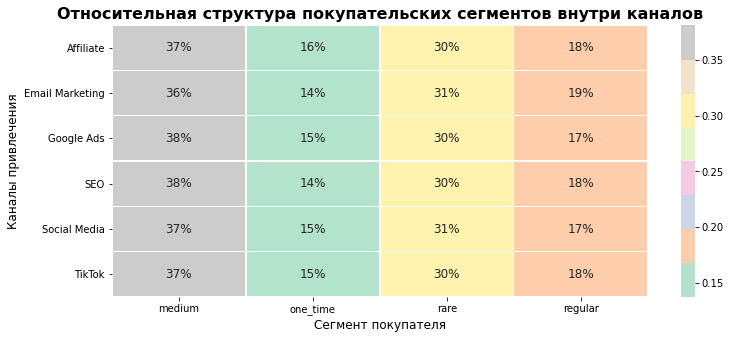

In [48]:
# Построим тепловую карту структуры покупательских сегментов внутри каналов в относительном выражении
plt.figure(figsize=(12, 5))

sns.heatmap(pivot_usr_ch_share,
            annot=True,
            cmap='Pastel2',
            fmt='.0%',
            linewidth=0.5,
            annot_kws={'size': 12})

plt.title('Относительная структура покупательских сегментов внутри каналов', fontsize=16, weight='bold')
plt.xlabel('Сегмент покупателя', fontsize=12)
plt.ylabel('Каналы привлечения', fontsize=12)
plt.show()

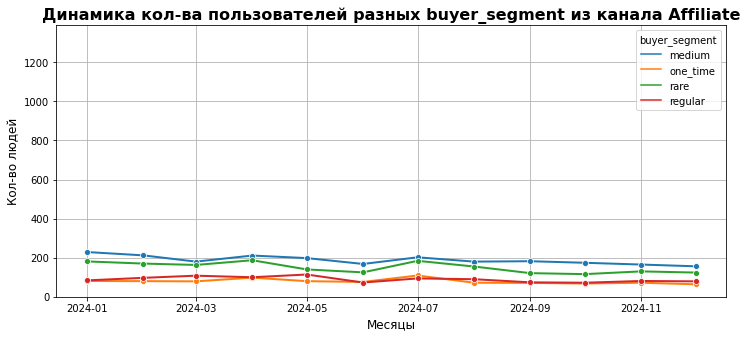

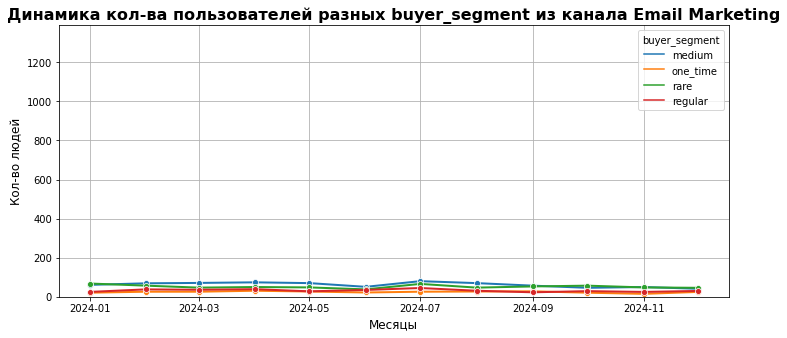

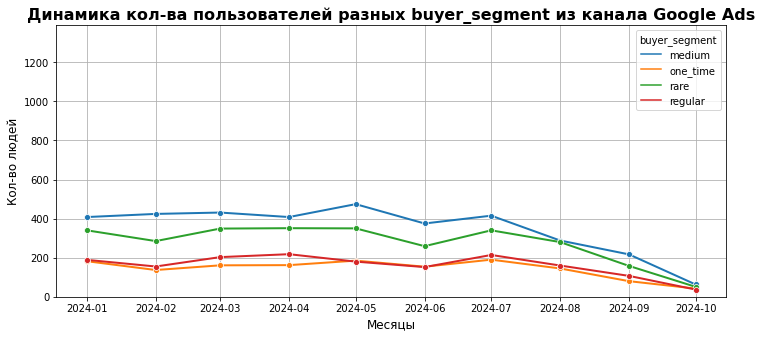

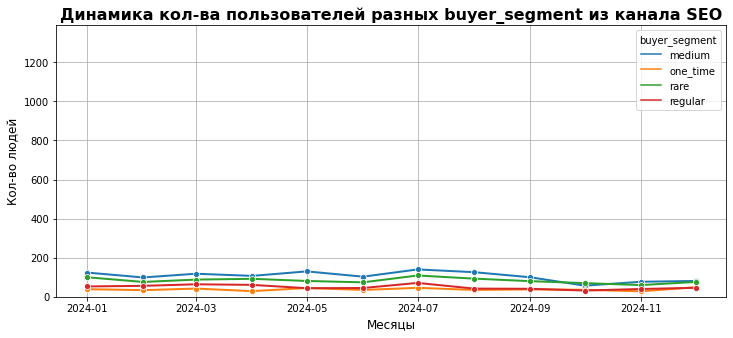

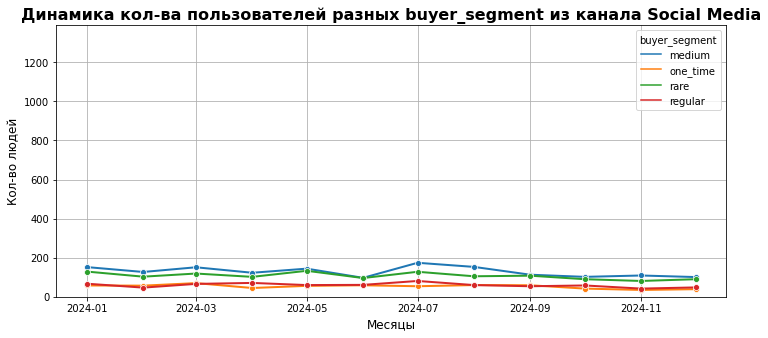

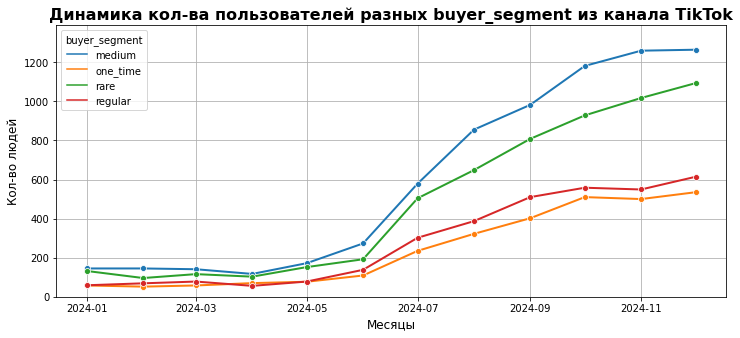

In [49]:
# Посмотрим динамику кол-ва пользователей разных buyer_segment для каждого канала acq_channel
segment_buyers_ch = pa_marketplace_users.groupby(['cohort_month', 'buyer_segment', 'acq_channel']) \
                                                                .user_id.nunique().reset_index()

 
for ch in segment_buyers_ch.acq_channel.unique():
    
    plt.figure(figsize=(12, 5))

    sns.lineplot(data=segment_buyers_ch[segment_buyers_ch.acq_channel == ch], x='cohort_month', y='user_id', hue='buyer_segment', marker='o', linewidth=2)

    plt.title(f'Динамика кол-ва пользователей разных buyer_segment из канала {ch}', fontsize=16, weight='bold')
    plt.xlabel('Месяцы', fontsize=12)
    plt.ylabel('Кол-во людей', fontsize=12)
    plt.ylim([0, segment_buyers_ch['user_id'].max() * 1.1])
    plt.grid(True)
    plt.show() 

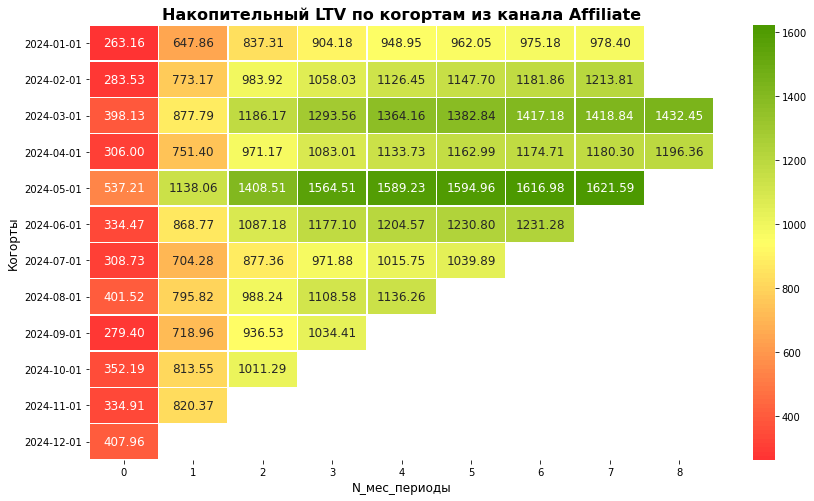

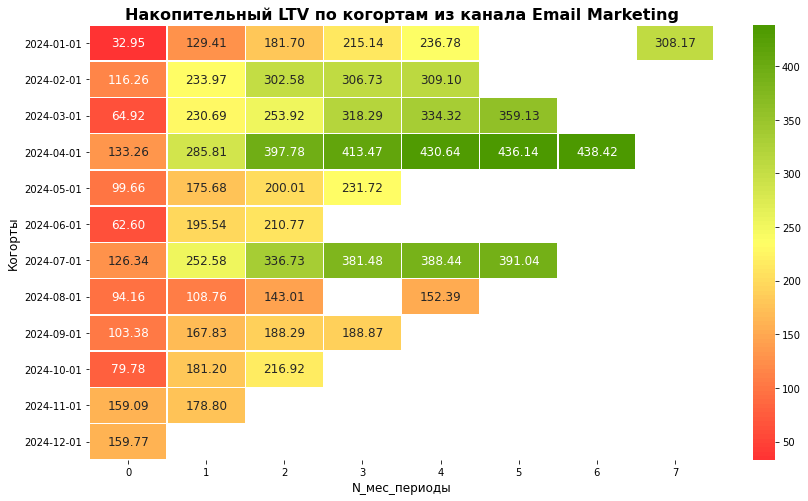

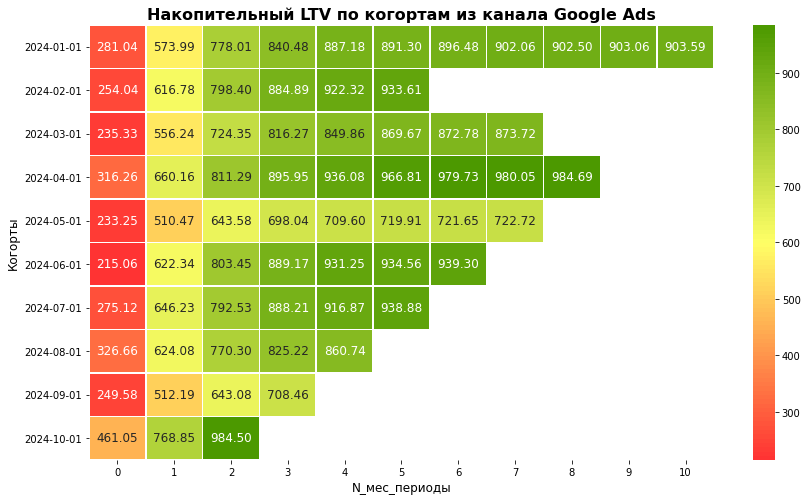

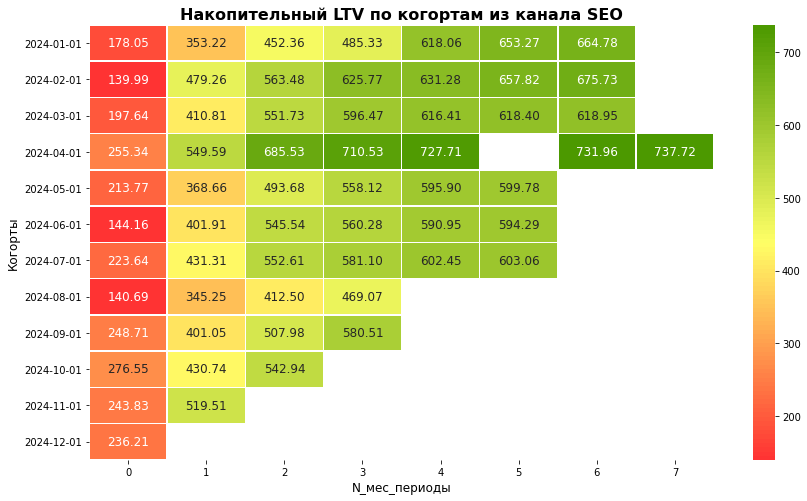

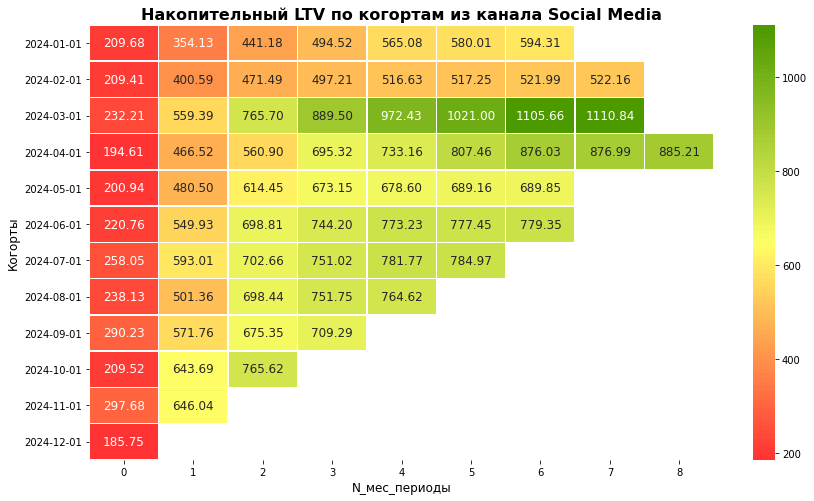

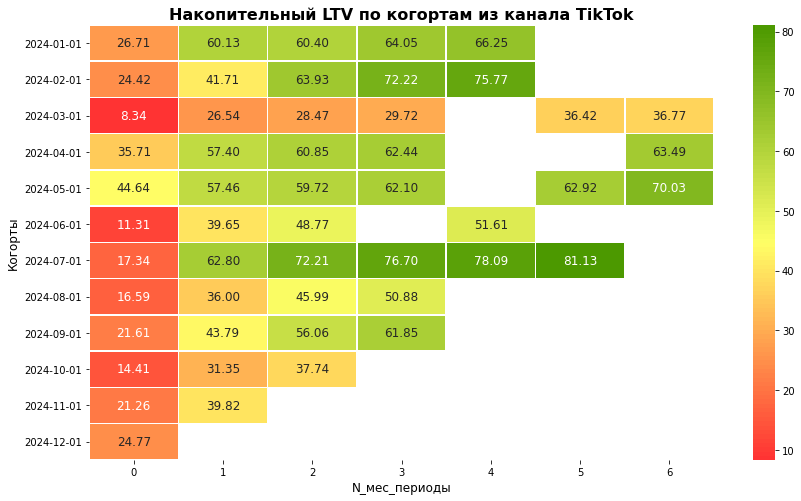

In [50]:
# Посчитаем накопленный LTV и ROI по когортам в разрезе acq_channel
# Посчитаем месяцы жизни когорт
df_orders_users['n_month'] = (df_orders_users['order_month'].dt.to_period('M').astype('int') - 
                              df_orders_users['cohort_month'].dt.to_period('M').astype('int'))
 
# Доход по когортам, acq_channel и месяцам жизни
revenue_by_cohort = df_orders_users.groupby(['cohort_month', 'acq_channel', 'n_month']).agg(gmv_cohort=('total_price', 'sum')).reset_index() 

# Размер когорт
cohort_size = pa_marketplace_users.groupby(['cohort_month', 'acq_channel']).agg(cohort_usr_cnt=('user_id', 'nunique')).reset_index()

# Добавим к df_orders_users размер когорт
revenue_by_cohort = revenue_by_cohort.merge(cohort_size, on=['cohort_month', 'acq_channel'], how='inner')

# Отсортируем revenue_by_cohort для корректной работы cumsum
revenue_by_cohort.sort_values(by=['acq_channel', 'cohort_month', 'n_month'], inplace=True)

# Посчитаем накопленную GMV в динамике на уровне когорт
revenue_by_cohort['gmv_cumsum'] = revenue_by_cohort.groupby(['acq_channel', 'cohort_month'])['gmv_cohort'].cumsum()

# Посчитаем накопленный LTV на каждого пользователя когорт, 
revenue_by_cohort['ltv'] = revenue_by_cohort['gmv_cumsum'] * 0.05 / revenue_by_cohort['cohort_usr_cnt']

# Посчитаем накопленный ROI по месячным когортам
roi_by_cohort = revenue_by_cohort[['cohort_month', 'n_month', 'ltv', 'acq_channel']].merge(df_CAC_ch, 
                                                                                           left_on=['cohort_month', 'acq_channel'], 
                                                                                           right_on=['spend_month', 'acq_channel'],
                                                                                           how='inner')
roi_by_cohort['roi'] = (roi_by_cohort.ltv - roi_by_cohort.cac) / roi_by_cohort.cac

# Построим визуализацию для накопительного LTV по месячным когортам в разрезе acq_channel
for ch in roi_by_cohort.acq_channel.unique():

    ltv_by_cohort_pivot = pd.pivot(roi_by_cohort[roi_by_cohort.acq_channel == ch],
                                  index='cohort_month',
                                  values='ltv',
                                  columns='n_month')


    ltv_by_cohort_pivot.index = pd.to_datetime(ltv_by_cohort_pivot.index).strftime('%Y-%m-%d')

    plt.figure(figsize=(14, 8))

    sns.heatmap(ltv_by_cohort_pivot,
                cmap=cmap,
                annot=True,
                fmt='.2f',
                linewidth=0.5,
                annot_kws={'size': 12})

    plt.title(f'Накопительный LTV по когортам из канала {ch}', fontsize=16, weight='bold')
    plt.xlabel('N_мес_периоды', fontsize=12)
    plt.ylabel('Когорты', fontsize=12)
    plt.show()

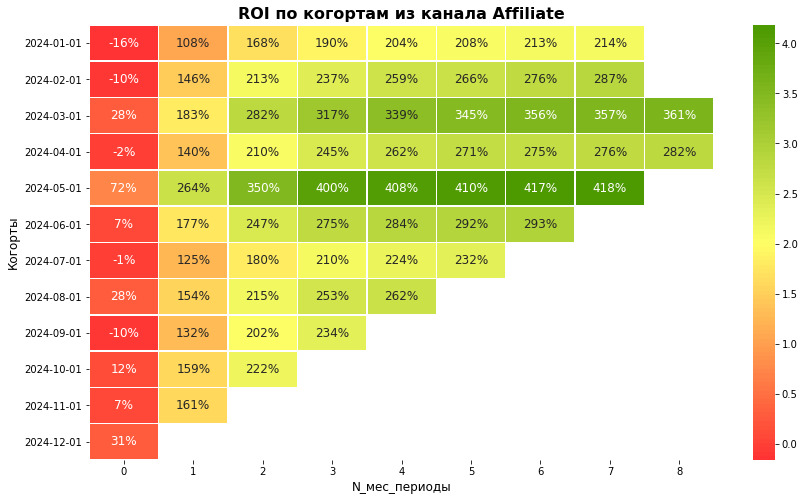

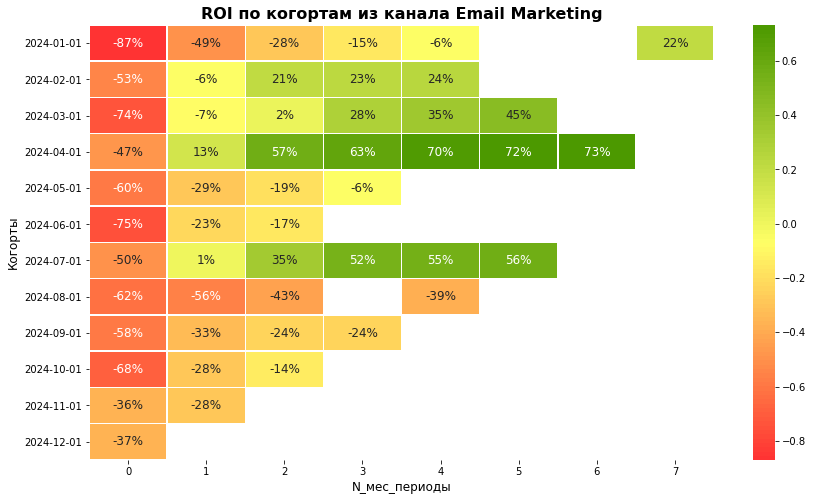

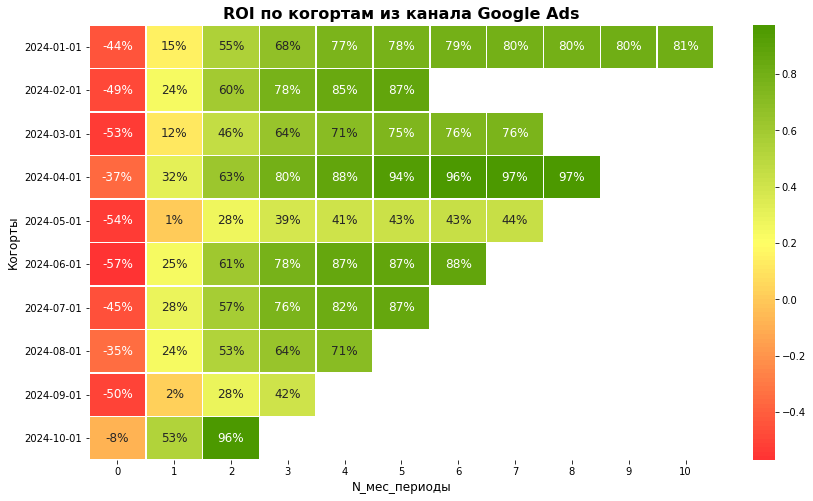

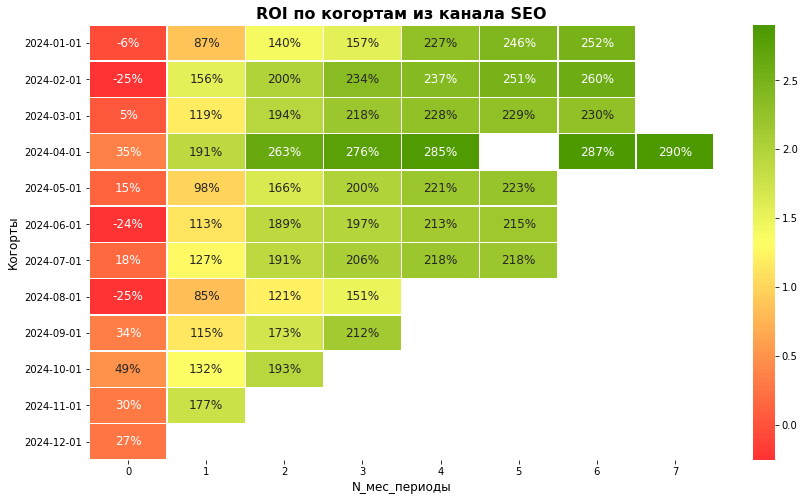

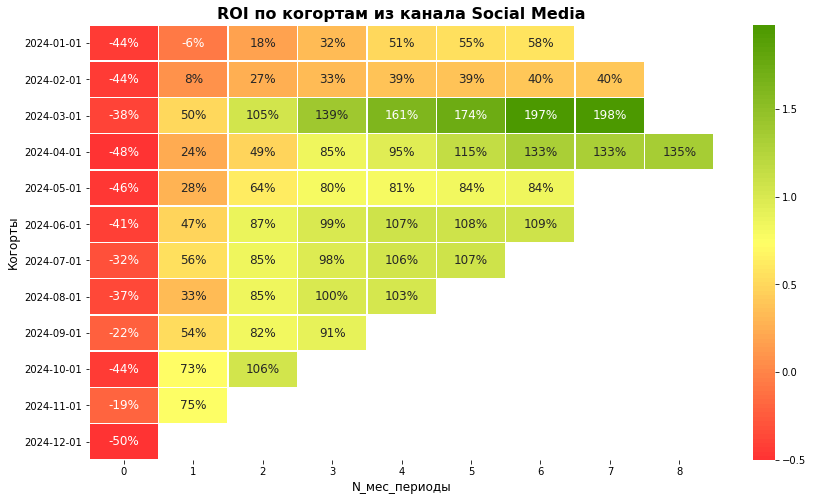

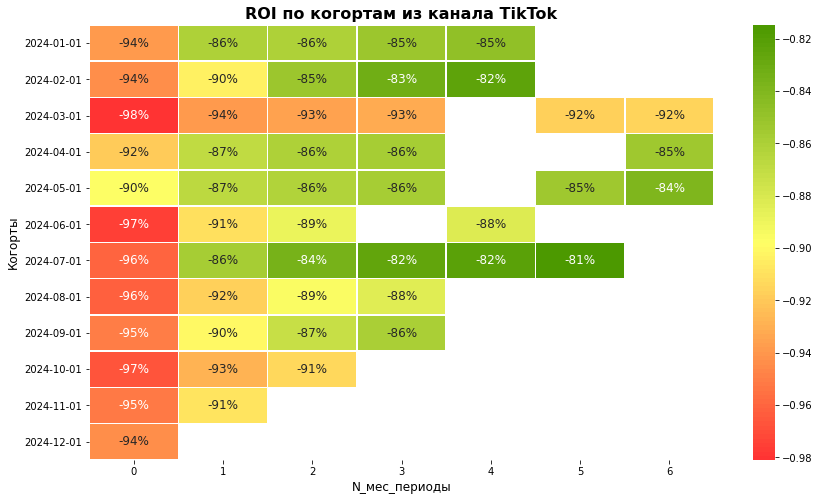

In [51]:
# Построим визуализацию для ROI по месячным когортам в разрезе acq_channel
for ch in roi_by_cohort.acq_channel.unique():
    
    roi_by_cohort_pivot = pd.pivot(roi_by_cohort[roi_by_cohort.acq_channel == ch],
                                  index='cohort_month',
                                  values='roi',
                                  columns='n_month')


    roi_by_cohort_pivot.index = pd.to_datetime(roi_by_cohort_pivot.index).strftime('%Y-%m-%d')

    plt.figure(figsize=(14, 8))

    sns.heatmap(roi_by_cohort_pivot,
                cmap=cmap,
                annot=True,
                fmt='.0%',
                linewidth=0.5,
                annot_kws={'size': 12})

    plt.title(f'ROI по когортам из канала {ch}', fontsize=16, weight='bold')
    plt.xlabel('N_мес_периоды', fontsize=12)
    plt.ylabel('Когорты', fontsize=12)
    plt.show()

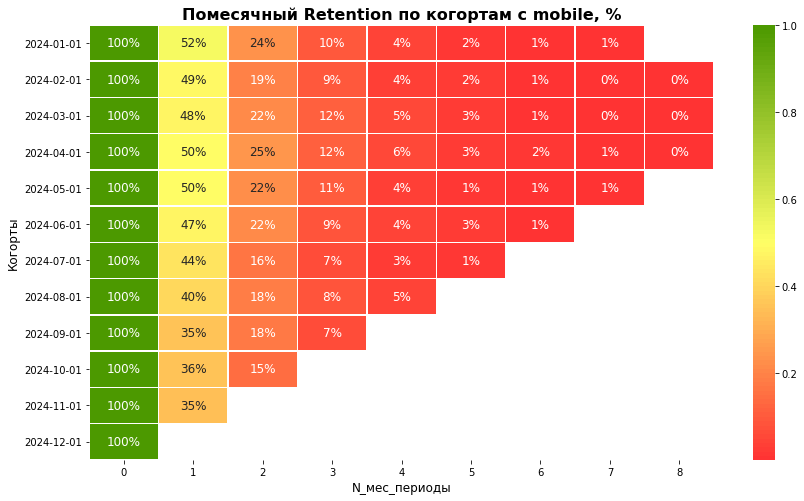

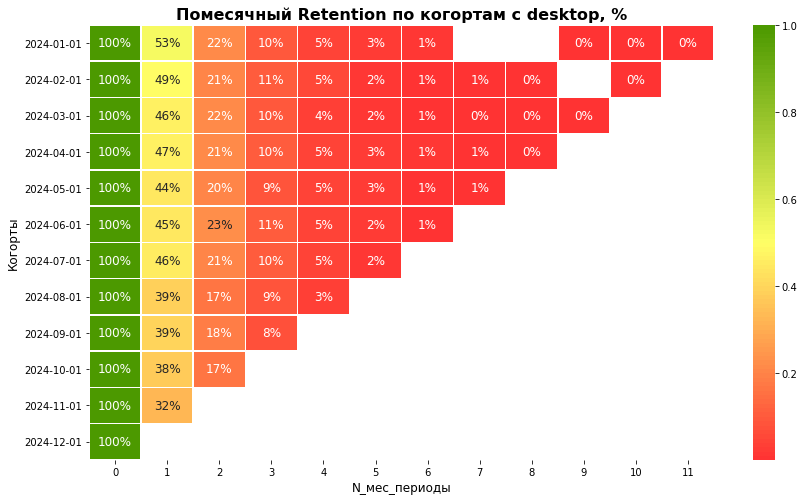

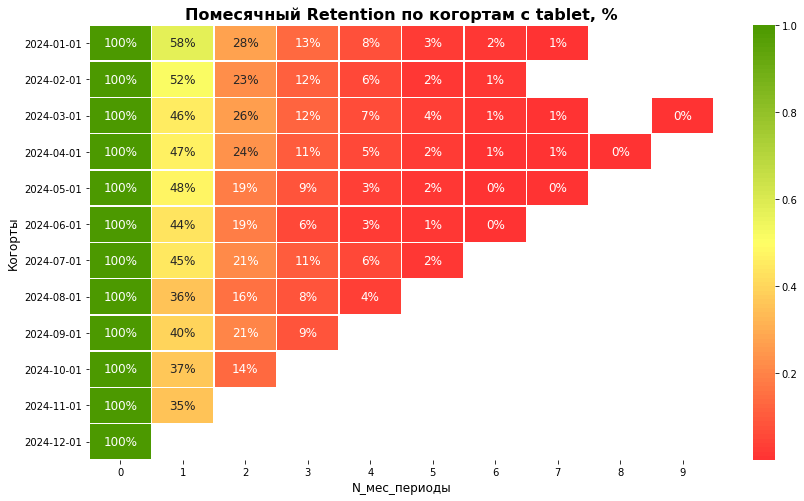

In [52]:
# Рассчитаем и визуализируем поведенческий Retention по месяцам в разрезе устройств
df_retention = df_event_users.copy()
df_retention['first_event_month'] = df_retention.groupby('user_id')['event_month'].transform('min')

df_retention['n_month'] = (df_retention['event_month'].dt.to_period('M').astype('int') 
                            - df_retention['first_event_month'].dt.to_period('M').astype('int'))

for eq in df_retention.device.unique():
    
    df_retention_pivot = pd.pivot_table(df_retention[df_retention.device == eq],
                                  index='first_event_month',
                                  values='user_id',
                                  columns='n_month',
                                  aggfunc='nunique')
    df_retention_pivot = df_retention_pivot.div(df_retention_pivot[0], axis=0)

    df_retention_pivot.index = pd.to_datetime(df_retention_pivot.index).strftime('%Y-%m-%d')

    plt.figure(figsize=(14, 8))

    sns.heatmap(df_retention_pivot,
                cmap=cmap,
                annot=True,
                fmt='.0%',
                linewidth=0.5,
                annot_kws={'size': 12})

    plt.title(f'Помесячный Retention по когортам c {eq}, %', fontsize=16, weight='bold')
    plt.xlabel('N_мес_периоды', fontsize=12)
    plt.ylabel('Когорты', fontsize=12)
    plt.show()

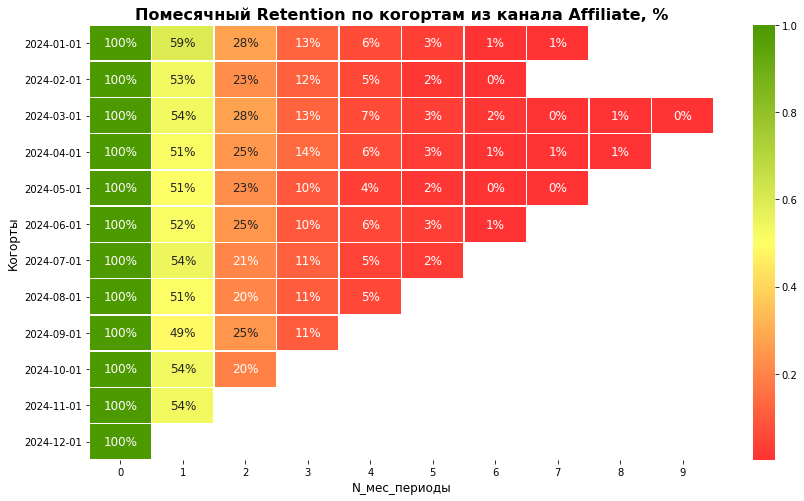

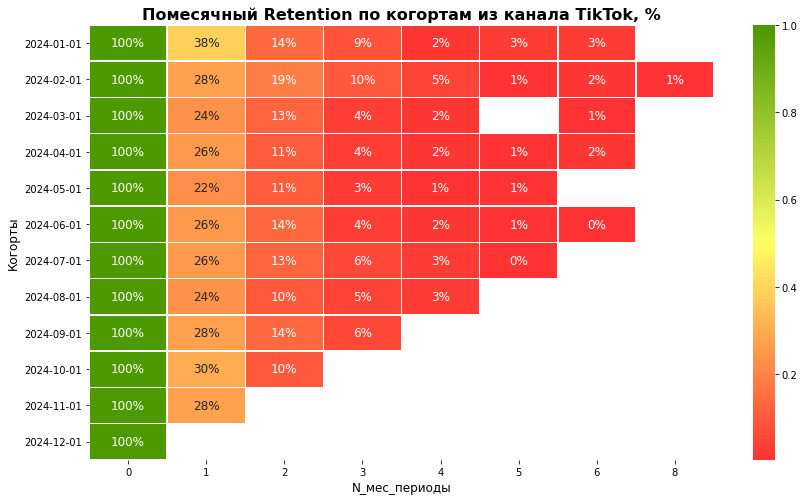

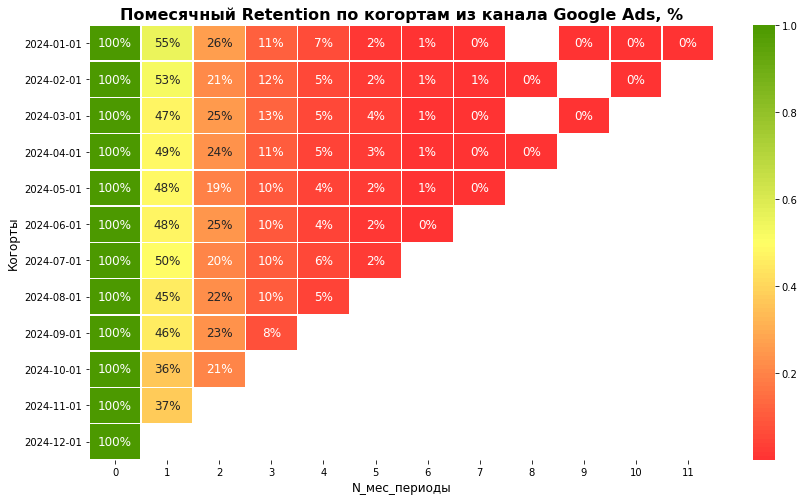

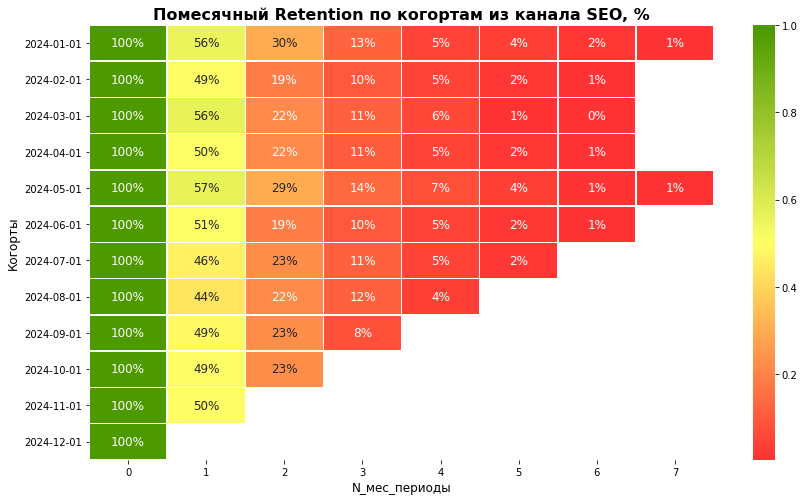

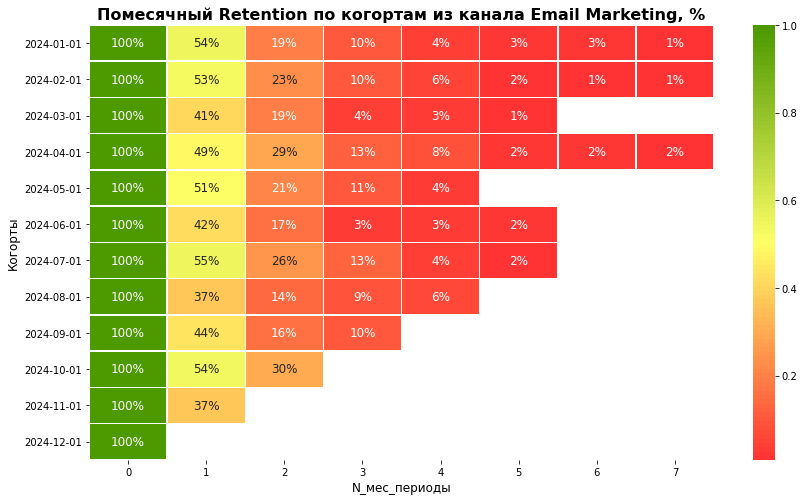

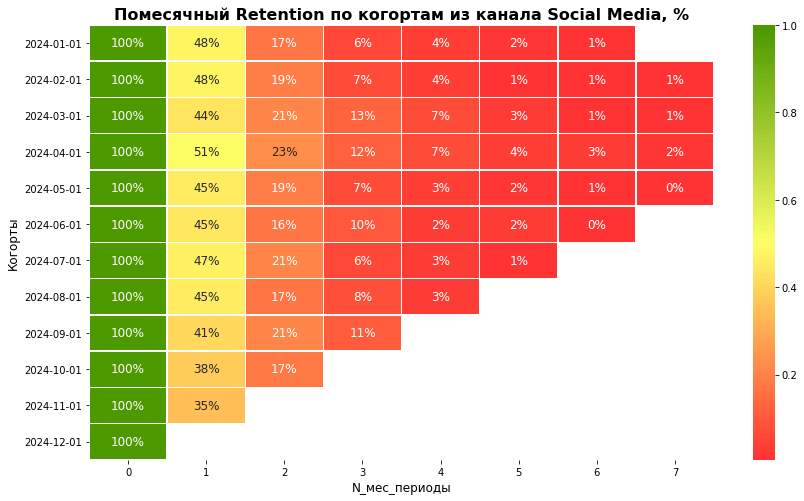

In [53]:
# Рассчитаем и визуализируем поведенческий Retention по месяцам в разрезе acq_channel
df_retention = df_event_users.copy()
df_retention['first_event_month'] = df_retention.groupby('user_id')['event_month'].transform('min')

df_retention['n_month'] = (df_retention['event_month'].dt.to_period('M').astype('int') 
                            - df_retention['first_event_month'].dt.to_period('M').astype('int'))

for ch in df_retention.acq_channel.unique():
    
    df_retention_pivot = pd.pivot_table(df_retention[df_retention.acq_channel == ch],
                                  index='first_event_month',
                                  values='user_id',
                                  columns='n_month',
                                  aggfunc='nunique')
    df_retention_pivot = df_retention_pivot.div(df_retention_pivot[0], axis=0)

    df_retention_pivot.index = pd.to_datetime(df_retention_pivot.index).strftime('%Y-%m-%d')

    plt.figure(figsize=(14, 8))

    sns.heatmap(df_retention_pivot,
                cmap=cmap,
                annot=True,
                fmt='.0%',
                linewidth=0.5,
                annot_kws={'size': 12})

    plt.title(f'Помесячный Retention по когортам из канала {ch}, %', fontsize=16, weight='bold')
    plt.xlabel('N_мес_периоды', fontsize=12)
    plt.ylabel('Когорты', fontsize=12)
    plt.show()

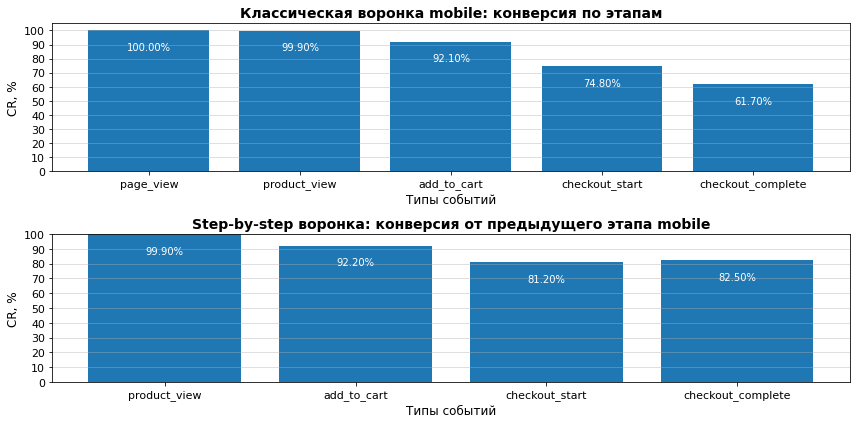

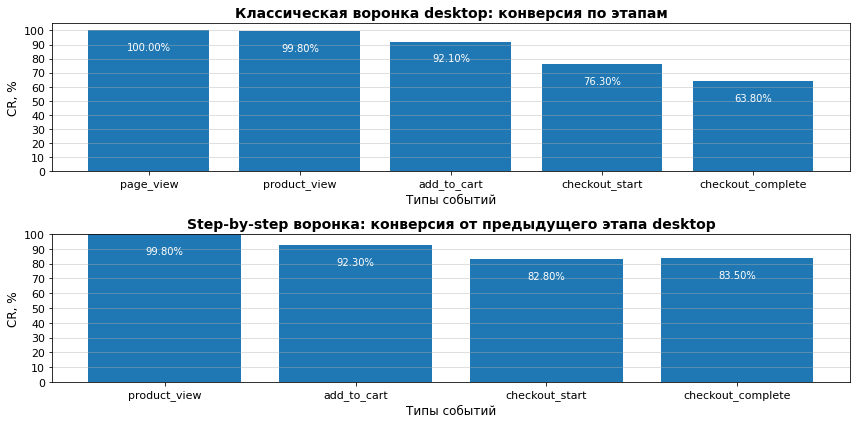

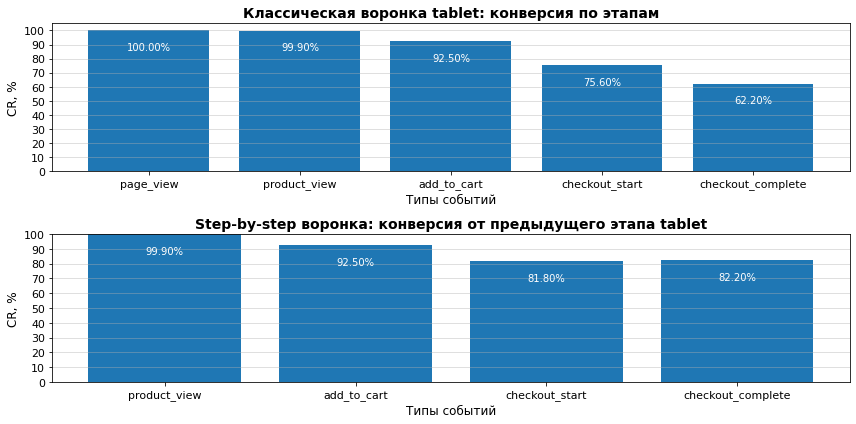

In [54]:
# Построим классическую(classic_CR) и step-by-step(sbs_CR) пользовательские воронки в покупку в разрезе устройств        
funel_with_segments('device')        

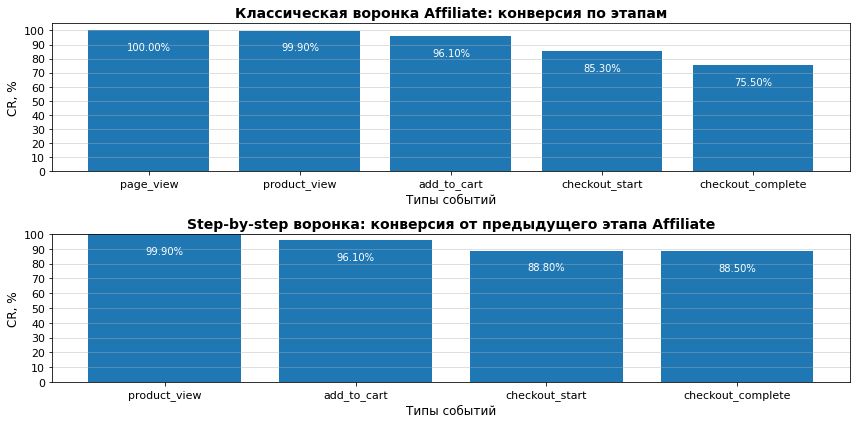

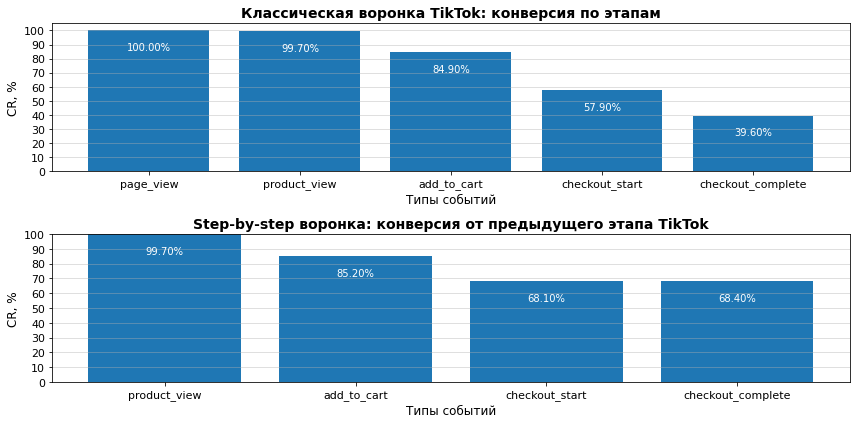

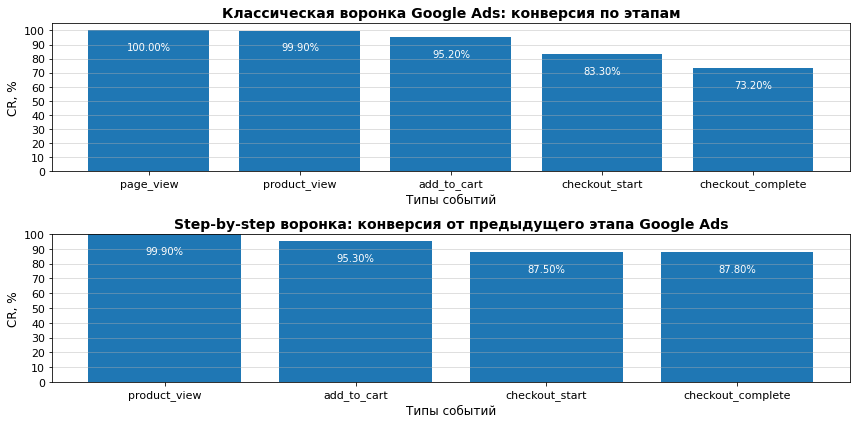

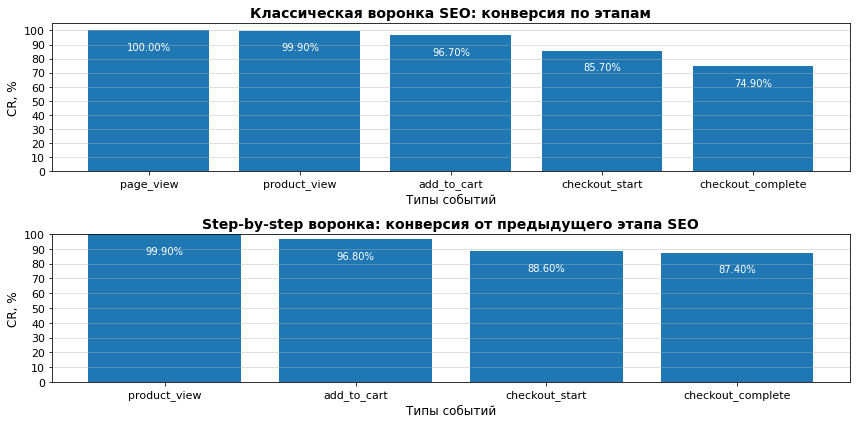

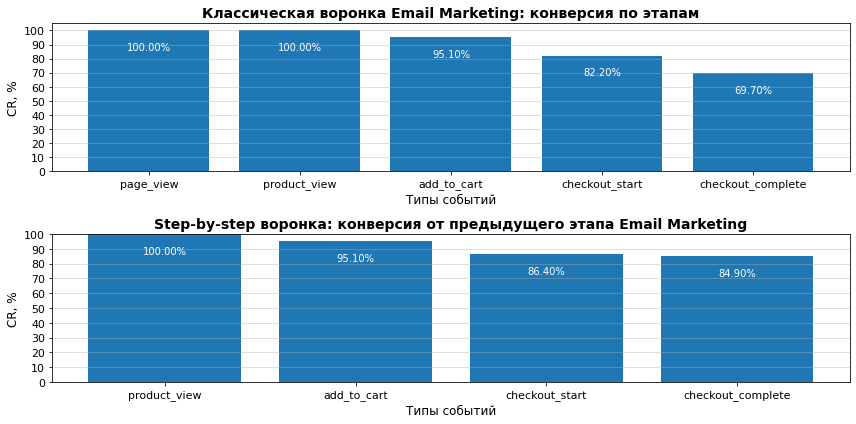

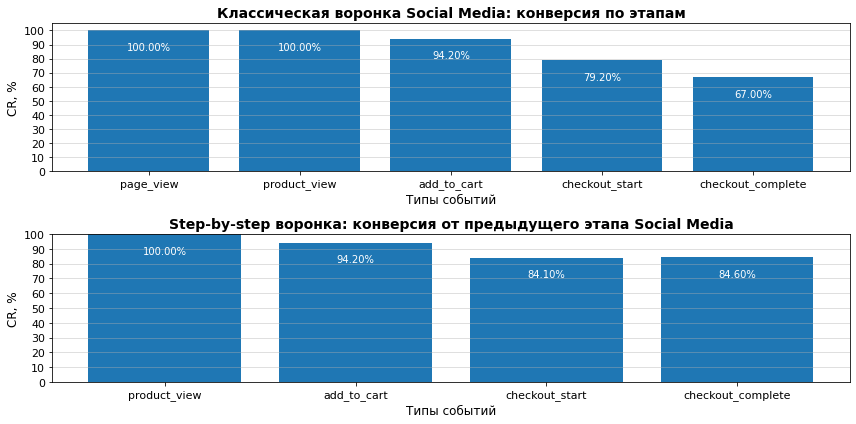

In [55]:
# Построим классическую(classic_CR) и step-by-step(sbs_CR) пользовательские воронки в покупку в разрезе каналов привлечения     
funel_with_segments('acq_channel') 

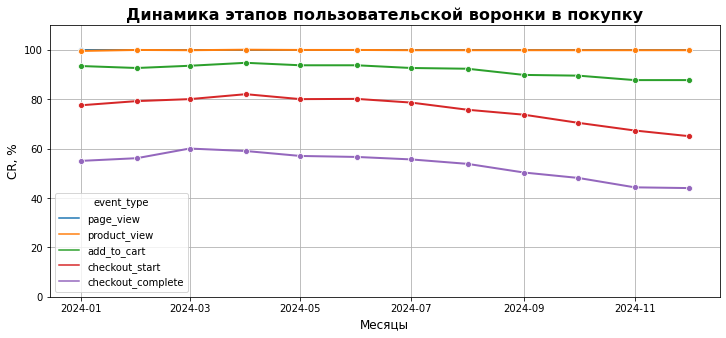

In [56]:
# Посмотрим на прохождение воронки в динамике
# Шаги воронки
funel_steps = ['page_view', 'product_view', 'add_to_cart', 'checkout_start', 'checkout_complete']

funel_list = []
for month in sorted(df_event_users['event_month'].unique()):
        

    funel_df = df_event_users[df_event_users['event_month'] == month].groupby('event_type') \
                        .agg(usr_cnt=('user_id', 'nunique')).reindex(funel_steps).reset_index()

    # Классическая конверсия на разных этапах воронки
    funel_df['classic_CR'] = funel_df.usr_cnt.div(funel_df.usr_cnt[0]).round(3) * 100
    funel_df['event_month'] = month

    funel_list.append(funel_df)
    
funel_df_dates = pd.concat(funel_list)
    
plt.figure(figsize=(12, 5))

sns.lineplot(data=funel_df_dates, x='event_month', y='classic_CR', hue='event_type', marker='o', linewidth=2)

plt.title('Динамика этапов пользовательской воронки в покупку', fontsize=16, weight='bold')
plt.xlabel('Месяцы', fontsize=12)
plt.ylabel('CR, %', fontsize=12)
plt.ylim([0, 110])
plt.grid(True)
plt.show() 

## Выводы по этапу 4

Представьте ключевые выводы в текстовом виде здесь или приложите ссылку на документ с презентацией.

Не забудьте предоставить доступ на просмотр и комментирование документа.

**Основные наблюдения и выводы:**

- Возраст пользователей рааспределен равномерно.
- MAU в разрезе регионов, сегментов покупателей, os устройств демонстрируют схожую динамику: кол-во пользователей растет до конца лета и далее идет откат к концу года.   
- MAU в разрезе источников привлечения уже имеют более разнонаправленную динамику: доля пользователей из GoogleAds падает к маю на 21% и после отскока в июле, падает к октябрю и исчезает; доля пользователей из Tick-Tok растет с мая по октябрь в 6 раз и далее падает к концу года почти вдвое с пика; остальные источники привлечения генерируют 100-200 пользователей в месяц, динамика привлечения стагнирует весь год. Структурное ухудшение качества аудитории - рост доли низкокачественного трафика (TikTok).
- Stickness деградирует:
    - Regular (постоянные покупатели) - падение с 35-40% до 25%.
    - Medium и Rare - умеренное снижение с 25-30% до 15-20%.
    - One_time - стабильно низкие показатели (5-10%) без значительных изменений. <br>
    Наиболее лояльный сегмент "regular" демонстрирует наибольшее относительное падение вовлеченности, что указывает на потерю ценности платформы для ядра аудитории.
    - Канал с наибольшим MAU (TikTok) имеет наихудший Stickiness - на уровне 5-15%, что в 4-6 раз хуже большинства других каналов.
    - Расхождений в динамике Stickness на разных os устройств не наблюдается.
- Несмотря на низкое качество пользователей с Tick-Tok, структура покупательских сегментов приходит в том же процентном соотношении, что и из других каналов.     
- Компания демонстрирует агрессивную стратегию увеличения маркетинговых инвестиций в течение 2024 года с ярко выраженным смещением фокуса в сторону канала TikTok. Самым дорогим по стоимости привлечения одного пользователя является Google Ads, который был основным первые пол года, далее идет TikTok. Email Marketing, SEO, Affiliate, СММ: бюджеты остаются минимальными (1-5% от общего).
- CR в покупку в разрезе каналов привлечения:
    - Лидеры конверсии:
        - Email Marketing: 50-60% (максимальная конверсия, но с небольшим снижением).
        - SEO: 40-50% (стабильно высокие показатели).
    - Средние показатели:
        - Google Ads: 30-40% (заметное падение с середины года).
        - Affiliate: 25-35% (относительная стабильность).
    - Аутсайдеры:
        - Social Media: 15-25% (низкая конверсия).
        - TikTok: 5-10% (катастрофически низкая, падение до минимальных значений). <br>
Канал с наибольшим MAU (TikTok) имеет наихудшую конверсию, тогда как каналы с минимальным трафиком (Email, SEO) показывают максимальную конверсию в покупку.
- CR в покупку в разрезе сегментов покупателей:
    - Regular покупатели: 40-70% конверсии.
    - Medium: 15-35% (умеренные показатели с негативным трендом).
    - One_time и Rare: 3-15% (стабильно низкая конверсия). <br>
Несмотря на высокую конверсию, сегмент regular показывает максимальное относительное падение (-40-50% от пиковых значений).
- Основные потери у пользователей TikTok при прохождении пользовательской воронки начинаются на последних двух этапах добавления в корзину и оформления заказа - теряется по 32% от предыдущего шага.
- Анализ накопительного LTV и ROI по каналам привлечения выявил радикальные различия в экономической эффективности. Канал Affiliate демонстрирует исключительную эффективность (LTV 1,600+ у.е., ROI до +400%, окупаемость на 2 месяц), тогда как TikTok является ниболее убыточным (LTV 30-80 у.е., ROI -82% до -94%, не окупается вовсе). При этом распределение маркетингового бюджета обратно пропорционально эффективности: на наиболее убыточный канал (TikTok) приходится 60-70% бюджета, тогда как наиболее эффективные каналы (Affiliate, Email, SEO) получают менее 10%. Email Marketing демонстрирует нестабильный ROI (от -87% до +73%): какие-то когорты окупаются на второй месяц, а какие-то не окупаются и на 5-ый.
- Схожую динамику с LTV и ROI демонстрирует и удержание: дольше всего задерживаются пользователи из канала Affilate, напротив, пользователи из Tick-Tok удерживатся первые 5 месяцев в 2 раза хуже. RR пользователей из Email Marketing от когорты к когорте нестабльно.

**Гипотезы:**

1. Оптимизация checkout-процесса для TikTok:
Если упростить оформление заказа для пользователей TikTok (покупка в один клик, оптимизировать кол-во обязательных полей, добавить социальный логин, оплата с автооткрытием приложения банка), то конверсия checkout_start → checkout_complete вырастет с 68% до 85%, увеличив общую конверсию канала на 24%.

2. Перераспределение маркетингового бюджета:
Если сократить бюджет TikTok на 60% и перенаправить в Affiliate, Email Marketing и Google Ads(предварительно оптимизировав стратегию и таргетинг привлечения последних двух каналов), то общий ROI маркетинга вырастет с отрицательного(новые когорты не окупаются) до +100% за 2 квартала.

3. Программа лояльности для регулярных покупателей:
Если внедрить многоуровневую программу лояльности с эксклюзивными условиями для сегмента regular, то их Stickiness восстановится с 20% до 35%, а частота покупок вырастет на 30%.

## 5. Подготовка эксперимента и подведение его результатов

Получите вводную информацию для выполнения этого этапа у ревьюера после успешного завершения предыдущих шагов.

# Новые вводные (после этапа 4)
Команда продукта рассмотрела твои гипотезы и на основании этого решила влиять на конверсию при помощи финансовых стимуляций. Так как ситуация со снижением выручки срочная и безотлагательная, пока ты продолжал изучать данные, они подключили другого аналитика для подготовки дизайн документа, но само проведение эксперимента на тебе.


При формировании выводов допиши рекомендации по итогам теста и, если необходимо, опиши проблемы, присутствующие в эксперименте.


## Новые данные:
```python
pa_marketplace_events_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_events_AB.csv')
pa_marketplace_orders_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_orders_AB.csv')
pa_marketplace_users_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_users_AB.csv')
```
## Результаты сплита лежат в таблице:
```python
pa_marketplace_AB_split_users = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_AB_split_users.csv')
```
* user_id – id клиента
* group – группа, в которую попал клиент


# Дизайн эксперимента: Бонус на первую покупку для пользователей TikTok
## 1. Контекст и цель эксперимента
- **Бизнес-контекст:** Команда продукта запускает эксперимент, направленный на повышение конверсии среди пользователей, привлечённых через канал TikTok. Для стимулирования первой покупки пользователям будет предоставлен бонус на первую покупку.
- **Цель:** Проверить, влияет ли предоставление бонуса на первую покупку на конверсию и выручку среди пользователей TikTok.
- **Гипотеза:** Предоставление бонуса на первую покупку новым пользователям, привлеченным через TikTok, приведет к увеличению конверсии в первую покупку
---
## 2. Формат эксперимента
- **Тип эксперимента:** Сплит-роллинг (rolling split)
- **Канал:** Только пользователи, пришедшие с TikTok
- **Группы:**
    - **Контрольная (A):** пользователи TikTok без бонуса
    - **Тестовая (B):** пользователи TikTok с бонусом на первую покупку
- **Распределение:** Равномерное распределение новых пользователей TikTok между группами по дате регистрации
- **Период проведения:** 3 недели (фиксировано)
---
## 3. Ключевые метрики
### Основная метрика
- **Конверсия в первую покупку** — доля пользователей, зарегистрировавшихся с TikTok и совершивших первую покупку
- *Цель:* увеличить конверсию с помощью бонуса
- *Критерий успеха:* статистически значимый рост конверсии в тестовой группе
### Вспомогательные метрики
- **ARPU** (средняя выручка на пользователя TikTok)
- **ARPPU** (средняя выручка на покупателя TikTok)
- **AOV** (средний чек TikTok)
### Барьерная метрика
- **Общая выручка от пользователей TikTok**
---
## 4. Размеры групп и запуск
- **Целевая аудитория:** только пользователи TikTok
- **Размеры групп:** определяются по фактическому трафику TikTok за период эксперимента
- **Комментарий:** запуск без предварительного расчёта мощности и MDE из-за срочности задачи


In [57]:
# Выгрузим данные для эксперимента
pa_marketplace_events_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_events_AB.csv')
pa_marketplace_orders_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_orders_AB.csv')
pa_marketplace_users_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_users_AB.csv')
pa_marketplace_AB_split_users = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_AB_split_users.csv')

In [58]:
# Посмотрим на данные экспериметна и преобразуем даты в datetime64
def quck_check_df(df, *args):
    display(df.sample(30))
    
    for i in args:
        df[i] = pd.to_datetime(df[i], errors='coerce')
    
    display(df.info())
    display(df.duplicated().sum())
    display(df.agg([min, max]))
    
quck_check_df(pa_marketplace_events_AB, 'event_date', 'event_week', 'event_month') 
quck_check_df(pa_marketplace_orders_AB, 'order_date', 'order_week', 'order_month')
quck_check_df(pa_marketplace_users_AB, 'registration_date', 'cohort_week', 'cohort_month')
quck_check_df(pa_marketplace_AB_split_users)

event_id  user_id           event_date         event_type       os  \
624560    663444    28938  2024-10-08 16:47:38      product_click    macOS   
651426    724677    33704  2024-10-21 14:29:05   remove_from_cart    macOS   
361627    398713    14908  2024-06-28 06:08:55      product_click  Android   
488234    582187    23872  2024-08-15 21:20:42       product_view    macOS   
616465    647707    27737  2024-10-05 00:48:26       product_view  Windows   
223338    258898     9585  2024-05-04 13:10:07       banner_click      iOS   
528898    495270    19378  2024-08-31 02:26:47      product_click    macOS   
89489      12628      403  2024-03-09 19:33:05       product_view      iOS   
317984    410375    15385  2024-06-10 05:11:08          page_view  Windows   
207878    229760     8494  2024-04-28 11:26:26     checkout_start  Android   
400117    354029    13064  2024-07-13 12:07:40      product_click  Android   
149936     65474     2547  2024-04-05 17:48:07             search    macOS   
252350    194584     7359  2024-05-16 01:08:28          page_view  Windows   
710298    491381    19139  2024-11-20 02:50:12        add_to_cart  Windows   
426903    466286    17902  2024-07-23 17:12:33       filter_apply  Windows   
701453    755380    36516  2024-11-15 13:34:21   remove_from_cart  Android   
87565     135617     5214  2024-03-09 00:14:30         user_login  Windows   
313615    298173    11018  2024-06-08 12:09:22      product_click  Android   
558984    648975    27855  2024-09-11 19:51:13      product_click  Windows   
804192    836718    44201  2025-01-11 13:03:23       wishlist_add      iOS   
98870     131818     5062  2024-03-14 18:43:31        add_to_cart      iOS   
131425     33547     1232  2024-03-29 03:28:12          page_view  Windows   
598459    601391    24898  2024-09-27 01:35:04      product_click      iOS   
276983     45520     1729  2024-05-25 04:14:39      product_click      iOS   
776759    687522    30651  2024-12-26 12:21:55          page_view    macOS   
594166    507081    19943  2024-09-25 09:07:46  checkout_complete      iOS   
718001    344398    12670  2024-11-23 21:52:09     checkout_start      iOS   
371034    310723    11371  2024-07-02 00:07:02       product_view  Windows   
265031    200172     7552  2024-05-20 17:42:48       product_view      iOS   
695519    735970    34665  2024-11-12 07:43:18      category_view  Android   

         device              product_name  event_week event_month  
624560  desktop             Брюки палаццо  2024-10-07  2024-10-01  
651426  desktop             Гречка ядрица  2024-10-21  2024-10-01  
361627   mobile          Носки спортивные  2024-06-24  2024-06-01  
488234  desktop        Мыло ручной работы  2024-08-12  2024-08-01  
616465   tablet         Палатка 3-местная  2024-09-30  2024-10-01  
223338   mobile                       NaN  2024-04-29  2024-05-01  
528898  desktop          Роман бестселлер  2024-08-26  2024-08-01  
89489   desktop               Набор ножей  2024-03-04  2024-03-01  
317984  desktop                       NaN  2024-06-10  2024-06-01  
207878   tablet                       NaN  2024-04-22  2024-04-01  
400117   tablet         Блендер погружной  2024-07-08  2024-07-01  
149936   tablet                       NaN  2024-04-01  2024-04-01  
252350   mobile                       NaN  2024-05-13  2024-05-01  
710298   tablet             Гири чугунные  2024-11-18  2024-11-01  
426903   tablet                       NaN  2024-07-22  2024-07-01  
701453   tablet              Spigen чехол  2024-11-11  2024-11-01  
87565    mobile                       NaN  2024-03-04  2024-03-01  
313615  desktop       Кровать двуспальная  2024-06-03  2024-06-01  
558984   mobile     Автомобильный пылесос  2024-09-09  2024-09-01  
804192   mobile  Холодильник двухкамерный  2025-01-06  2025-01-01  
98870    tablet           Бинт эластичный  2024-03-11  2024-03-01  
131425   mobile                       NaN  2024-03-25  2024-03-01  
598459   tablet          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831231 entries, 0 to 831230
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_id      831231 non-null  int64         
 1   user_id       831231 non-null  int64         
 2   event_date    831231 non-null  datetime64[ns]
 3   event_type    831231 non-null  object        
 4   os            831231 non-null  object        
 5   device        831231 non-null  object        
 6   product_name  409054 non-null  object        
 7   event_week    831231 non-null  datetime64[ns]
 8   event_month   831231 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 57.1+ MB


None

0

event_id  user_id          event_date    event_type       os   device  \
min         1        2 2024-01-01 15:23:56   add_to_cart  Android  desktop   
max    873327    48901 2025-01-26 23:59:34  wishlist_add    macOS   tablet   

    event_week event_month  
min 2024-01-01  2024-01-01  
max 2025-01-20  2025-01-01

order_id  user_id               order_date          product_name  \
10849     10850     9791  2024-08-23 17:14:19.000      Рис длиннозерный   
9960       9961     9050  2024-04-15 18:50:35.000           Калькулятор   
17661     17662    16056  2024-07-03 09:35:29.000       Комод с ящиками   
13319     13320    11697  2024-04-30 05:45:55.000     Поводок и ошейник   
31007     31257    41662  2024-12-26 05:53:16.000         Гречка ядрица   
7183       7184     6768  2024-04-27 00:51:16.000         Пальто зимнее   
15985     15986    14304  2024-05-28 06:38:35.000        Зеркало в раме   
2707       2708     2644  2024-07-15 03:32:38.000         Крем для лица   
7205       7206     6793  2024-06-04 06:47:58.000         Топ кружевной   
12647     12648    11214  2024-05-21 08:30:55.000            Брюки чино   
17997     17998    16442  2024-07-28 15:20:57.000        Кресло офисное   
17481     17482    15867  2024-07-11 02:58:43.000           AirPods Pro   
3357       3358     3220  2024-02-21 04:51:10.000        Джинсы детские   
13136     13137    11525  2024-05-24 06:55:39.000          Кукла Barbie   
23177     23185    22577  2024-08-16 04:05:38.000      Роман бестселлер   
5523       5524     5298  2024-04-20 05:54:00.000             Юбка миди   
12521     12522    11106  2024-06-14 09:14:56.000        Сапоги высокие   
10082     10083     9142  2024-07-24 21:20:59.000  Самокат трехколесный   
2416       2417     2355  2024-02-03 21:54:37.000        Ремень кожаный   
11076     11077     9968  2024-05-16 12:59:49.000           Сахар белый   
10556     10557     9541  2024-04-22 03:15:15.000      Шарф кашемировый   
28044     28097    31556  2024-12-23 21:16:27.000     Поводок и ошейник   
26386     26411    27854  2024-10-20 07:25:14.000        Мука пшеничная   
21667     21673    20606  2024-08-01 21:05:40.000     Велосипед детский   
19531     19534    17927  2024-09-10 13:22:05.000            Кофемашина   
25959     25982    27228  2024-09-09 04:29:41.000      Кроватка детская   
8879       8880     8104  2024-05-15 17:50:36.000  Рубашка классическая   
12387     12388    11009  2024-06-15 12:07:40.000       Маркеры цветные   
19094     19097    17526  2024-09-04 02:38:12.000      Роман бестселлер   
6359       6360     6075  2024-03-13 16:40:08.000        Ремень кожаный   

       quantity  unit_price  total_price             category_name  \
10849         1      618.00       618.00          Продукты питания   
9960          2     1135.25      2270.50        Книги и канцтовары   
17661         3    32655.91     97967.73           Мебель для дома   
13319         1     2315.37      2315.37                 Зоотовары   
31007         1     2176.23      2176.23          Продукты питания   
7183          2     2401.55      4803.10            Женская одежда   
15985         3     2779.05      8337.15         Декор и освещение   
2707          1     3922.27      3922.27    Косметика и парфюмерия   
7205          2     7976.81     15953.62            Женская одежда   
12647         2     2048.29      4096.58            Мужская одежда   
17997         3    18008.38     54025.14           Мебель для дома   
17481         1     3446.70      3446.70   Аксессуары для гаджетов   
3357          1     1469.69      1469.69            Детская одежда   
13136         1     1237.20      1237.20           Детские игрушки   
23177         1     1427.13      1427.13        Книги и канцтовары   
5523          2     2122.44      4244.88            Женская одежда   
12521         1    10226.90     10226.90             Обувь женская   
10082         3     5072.14     15216.42           Детские игрушки   
2416          1     9819.24      9819.24        Сумки и аксессуары   
11076         3      532.73      1598.19          Продукты питания   
10556         3    10661.44     31984.32        Сумки и аксессуары   
28044         2     2315.37      4630.74                 Зоотовары   
26386         3     2179.75      6539.25          Продукты питания   
2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33280 entries, 0 to 33279
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       33280 non-null  int64         
 1   user_id        33280 non-null  int64         
 2   order_date     33280 non-null  datetime64[ns]
 3   product_name   33280 non-null  object        
 4   quantity       33280 non-null  int64         
 5   unit_price     33280 non-null  float64       
 6   total_price    33280 non-null  float64       
 7   category_name  33280 non-null  object        
 8   order_week     33280 non-null  datetime64[ns]
 9   order_month    33280 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(3), object(2)
memory usage: 2.5+ MB


None

0

order_id  user_id          order_date product_name  quantity  unit_price  \
min         1        3 2024-01-01 08:03:45  AirPods Pro         1      218.82   
max     38848    48789 2025-01-26 23:07:50    Юбка миди         3    63932.38   

     total_price     category_name order_week order_month  
min       218.82        Автотовары 2024-01-01  2024-01-01  
max    191797.14  Украшения и часы 2025-01-20  2025-01-01

user_id    registration_date  age gender              region  \
13023    36686  2024-11-06 16:15:00   54      M              Москва   
7160     27994  2024-09-08 13:36:00   23      F     Санкт-Петербург   
6329     26524  2024-08-30 21:39:00   41      F      Ростов-на-Дону   
4901     23692  2024-08-10 17:29:00   49      F              Москва   
5142     24188  2024-08-13 18:12:00   31      F              Москва   
2345     16637  2024-06-18 04:58:00   30      M              Москва   
1584     12572  2024-05-07 15:45:00   18      F              Москва   
4857     23597  2024-08-09 06:35:00   37      F     Санкт-Петербург   
8589     30414  2024-09-23 00:14:00   29      M      Другие регионы   
10076    32638  2024-10-09 08:29:00   25      F           Краснодар   
1381     10846  2024-04-20 10:18:00   21      F     Нижний Новгород   
724       5586  2024-02-27 09:05:00   68      F        Екатеринбург   
7537     28635  2024-09-12 11:23:00   35      M      Другие регионы   
4615     23057  2024-08-06 19:06:00   26      F              Москва   
14754    39019  2024-11-22 15:28:00   39      M     Санкт-Петербург   
10572    33369  2024-10-14 17:59:00   44      F        Екатеринбург   
7017     27758  2024-09-06 14:24:00   47      M      Другие регионы   
4054     21701  2024-07-27 16:38:00   59      M        Екатеринбург   
13746    37658  2024-11-13 00:11:00   60      F     Санкт-Петербург   
11816    35105  2024-10-27 22:41:00   30      F      Другие регионы   
3973     21521  2024-07-25 11:53:00   43      F              Москва   
20529    46686  2025-01-11 15:01:00   51      M              Москва   
640       5027  2024-02-21 04:17:00   56      F      Другие регионы   
16330    41121  2024-12-06 18:14:00   41      M      Другие регионы   
9774     32191  2024-10-06 19:04:00   68      M         Новосибирск   
3556     20442  2024-07-18 08:47:00   47      M      Другие регионы   
12544    36058  2024-11-02 05:19:00   43      F      Другие регионы   
7547     28651  2024-09-12 06:26:00   37      F      Другие регионы   
14734    38996  2024-11-21 17:38:00   64      M  Московская область   
18120    43523  2024-12-21 08:12:00   62      M              Москва   

      acq_channel buyer_segment cohort_week cohort_month  
13023      TikTok      one_time  2024-11-04   2024-11-01  
7160       TikTok          rare  2024-09-02   2024-09-01  
6329       TikTok        medium  2024-08-26   2024-08-01  
4901       TikTok       regular  2024-08-05   2024-08-01  
5142       TikTok      one_time  2024-08-12   2024-08-01  
2345       TikTok        medium  2024-06-17   2024-06-01  
1584       TikTok        medium  2024-05-06   2024-05-01  
4857       TikTok      one_time  2024-08-05   2024-08-01  
8589       TikTok       regular  2024-09-23   2024-09-01  
10076      TikTok       regular  2024-10-07   2024-10-01  
1381       TikTok        medium  2024-04-15   2024-04-01  
724        TikTok        medium  2024-02-26   2024-02-01  
7537       TikTok          rare  2024-09-09   2024-09-01  
4615       TikTok          rare  2024-08-05   2024-08-01  
14754      TikTok        medium  2024-11-18   2024-11-01  
10572      TikTok      one_time  2024-10-14   2024-10-01  
7017       TikTok        medium  2024-09-02   2024-09-01  
4054       TikTok       regular  2024-07-22   2024-07-01  
13746      TikTok        medium  2024-11-11   2024-11-01  
11816      TikTok      one_time  2024-10-21   2024-10-01  
3973       TikTok        medium  2024-07-22   2024-07-01  
20529      TikTok        medium  2025-01-06   2025-01-01  
640        TikTok        medium  2024-02-19   2024-02-01  
16330      TikTok       regular  2024-12-02   2024-12-01  
9774       TikTok       regular  2024-09-30   2024-10-01  
3556       TikTok      one_time  2024-07-15   2024-07-01  
12544      TikTok          rare  2024-10-28   2024-11-01  
7547       TikTok        medium  2024-09-09   2024-09-01  
14734      TikTok          rare  2024-11-18   2024-11-01  
18120      TikTok          rare  20

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22196 entries, 0 to 22195
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            22196 non-null  int64         
 1   registration_date  22196 non-null  datetime64[ns]
 2   age                22196 non-null  int64         
 3   gender             22196 non-null  object        
 4   region             22196 non-null  object        
 5   acq_channel        22196 non-null  object        
 6   buyer_segment      22196 non-null  object        
 7   cohort_week        22196 non-null  datetime64[ns]
 8   cohort_month       22196 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 1.5+ MB


None

0

user_id   registration_date  age gender           region acq_channel  \
min       18 2024-01-01 01:13:00   18      F   Другие регионы      TikTok   
max    48907 2025-01-26 23:41:00   70      M  Санкт-Петербург      TikTok   

    buyer_segment cohort_week cohort_month  
min        medium  2024-01-01   2024-01-01  
max       regular  2025-01-20   2025-01-01

user_id      group
539     45692  treatment
720     45929  treatment
2369    48097  treatment
909     46175  treatment
176     45204    control
2799    48684  treatment
2664    48486    control
2652    48468    control
271     45345  treatment
1488    46942    control
1782    47334  treatment
2450    48200  treatment
2366    48089  treatment
1996    47625    control
1523    46981  treatment
294     45374    control
2114    47774  treatment
2481    48238    control
63      45045  treatment
1357    46764    control
2605    48404    control
2198    47879  treatment
1218    46569    control
897     46160  treatment
1905    47503  treatment
943     46215    control
638     45822  treatment
2410    48146    control
1425    46860  treatment
1500    46954  treatment

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  2968 non-null   int64 
 1   group    2968 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.5+ KB


None

0

user_id      group
min    44965    control
max    48907  treatment

In [59]:
# Проверим наличие пользователей, которые попали в обе группы
flawed_users = pa_marketplace_AB_split_users.groupby('user_id').group.nunique().reset_index()
flawed_users[flawed_users.group > 1]

Empty DataFrame
Columns: [user_id, group]
Index: []

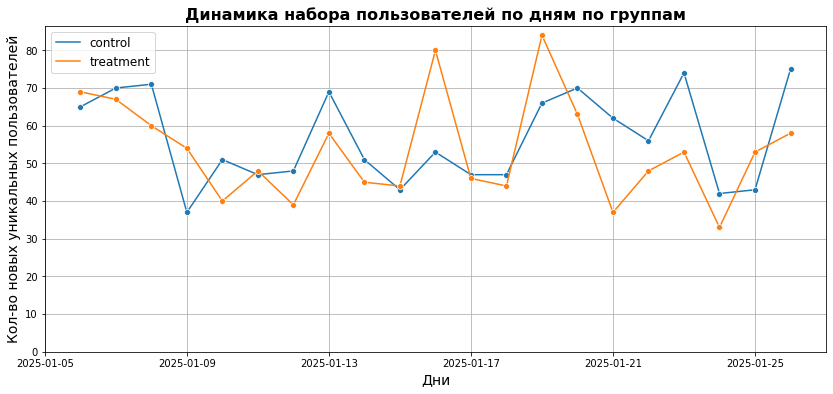

In [60]:
# Посмотрим на динамику набора зарегистрированных пользователей из Тик-Ток по эксп. группам
df_ab_users = pd.merge(pa_marketplace_users_AB, pa_marketplace_AB_split_users, on='user_id', how='inner')

# Отфильтруем пользователей с registration_date < 2025-01-06 
df_ab_users = df_ab_users[df_ab_users['registration_date'] >= '2025-01-06']

# Уберем из registration_date время
df_ab_users['registration_date'] = df_ab_users['registration_date'].dt.date

df_grouped = df_ab_users.groupby(['registration_date', 'group']).user_id.nunique().reset_index()

# Построим график динамики набора групп пользователей по дням
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_grouped, x='registration_date', y='user_id', hue='group', marker='o', ci=None) 

plt.title('Динамика набора пользователей по дням по группам', fontsize=16, weight='bold')
plt.xlabel('Дни', fontsize=14)
plt.ylabel('Кол-во новых уникальных пользователей', fontsize=14)
plt.legend(fontsize=12)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

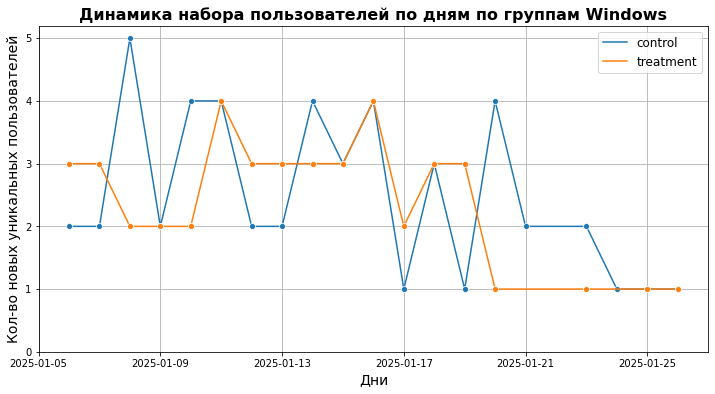

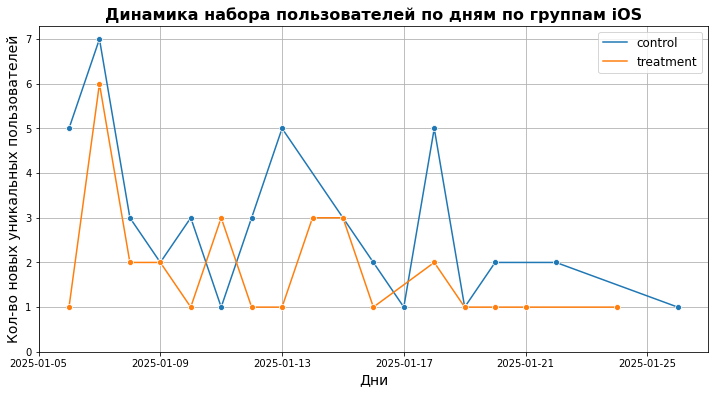

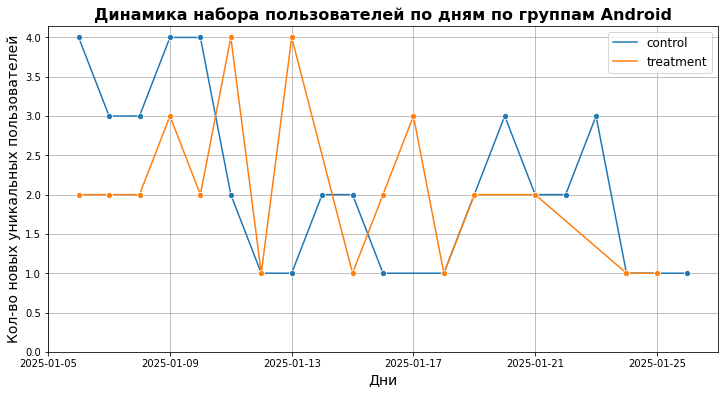

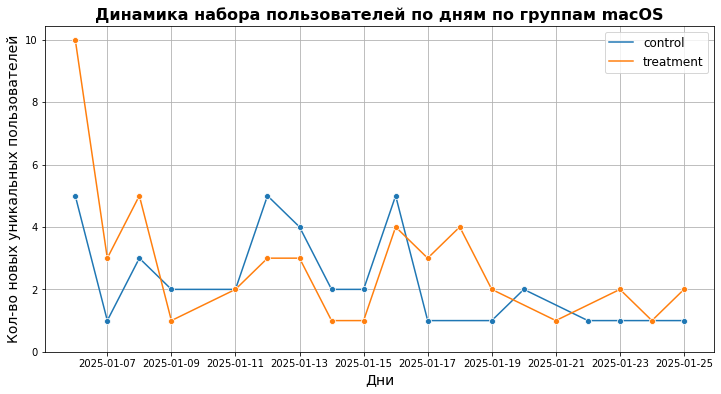

In [61]:
# Посмотрим на динамику набора пользователей, для которых есть события в pa_marketplace_events_AB по группам в разрезе os
df_ab_users_events = df_ab_users.merge(pa_marketplace_events_AB, on='user_id', how='inner')

for o in df_ab_users_events.os.unique():
    # Посмотрим на динамику набора пользователей по группам
    df_grouped_o = df_ab_users_events.query('os == @o') \
                                    .groupby(['registration_date', 'group']).user_id.nunique().reset_index()

    # Построим график динамики набора групп пользователей по дням
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_grouped_o, x='registration_date', y='user_id', hue='group', marker='o', ci=None) 

    plt.title(f'Динамика набора пользователей по дням по группам {o}', fontsize=16, weight='bold')
    plt.xlabel('Дни', fontsize=14)
    plt.ylabel('Кол-во новых уникальных пользователей', fontsize=14)
    plt.legend(fontsize=12)
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.show() 
           

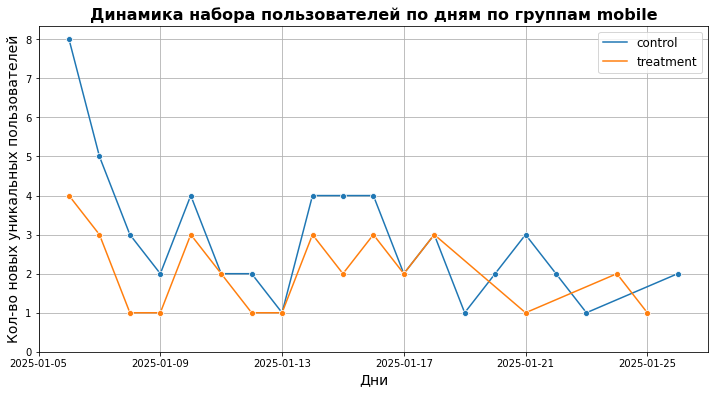

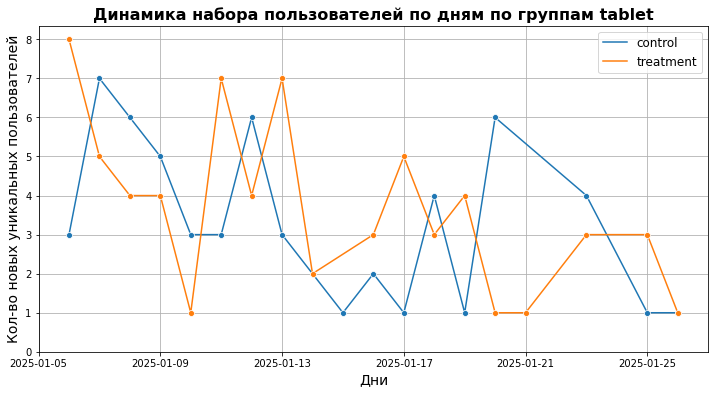

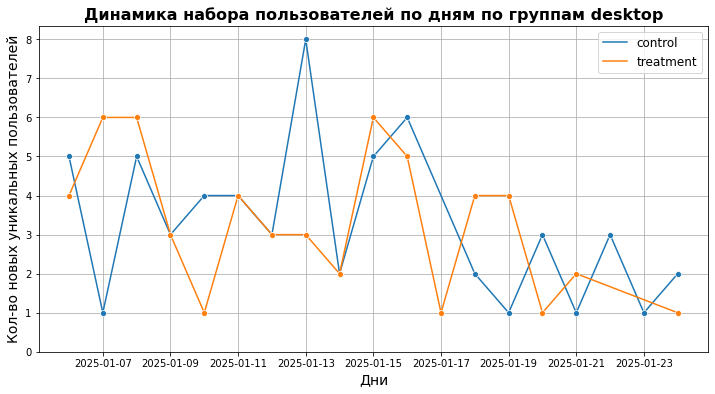

In [62]:
# Посмотрим на динамику набора пользователей, для которых есть события в pa_marketplace_events_AB по группам в разрезе device
for eq in df_ab_users_events.device.unique():
    # Посмотрим на динамику набора пользователей по группам
    df_grouped_eq = df_ab_users_events.query('device == @eq') \
                                    .groupby(['registration_date', 'group']).user_id.nunique().reset_index()

    # Построим график динамики набора групп пользователей по дням
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_grouped_eq, x='registration_date', y='user_id', hue='group', marker='o', ci=None) 

    plt.title(f'Динамика набора пользователей по дням по группам {eq}', fontsize=16, weight='bold')
    plt.xlabel('Дни', fontsize=14)
    plt.ylabel('Кол-во новых уникальных пользователей', fontsize=14)
    plt.legend(fontsize=12)
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.show() 

In [63]:
# Проверим, что экспериментальные группы зарегистрированных пользователей из Тик-Ток примерно равные по размеру
df_ab_users.groupby('group').user_id.nunique()

group
control      1187
treatment    1123
Name: user_id, dtype: int64

- Нет пользователей в обеих группах сразу.
- На основном графике распределения пользователей по группам видно, что набор пользователей в контрольную и тестовую группы происходит синхронно и равномерно. Отсутствуют явные смещения во времени - линии идут параллельно.
- На всех графиках Windows, iOS, Android, macOS, tablet, mobile, desktop наблюдается похожая картина — линии контрольной и тестовой групп колеблются, но в целом остаются близко друг к другу. Нет резких расхождений, которые могли бы указывать на проблемы со сплитованием для конкретных платформ.
- Разница между кол-вом пользователей в обоих выборках невелика.

In [64]:
# Сформируем датасет для анализа
df_analysis_AB = pa_marketplace_orders_AB.merge(df_ab_users, on='user_id', how='right')
df_analysis_AB['is_buyer'] = df_analysis_AB.order_id.notna().astype(int)

In [65]:
# Посчитаем кумулятивные данные метрик эксперимента

records = []
for dt in sorted(df_analysis_AB.registration_date.unique()):
    filtered_data = df_analysis_AB[df_analysis_AB.registration_date <= dt]
    
    grouped_df = filtered_data.groupby('group', as_index=False).agg(
            gmv=('total_price', 'sum'),
            reg_usr=('user_id', 'nunique'))
    
    grouped_df_purch = filtered_data[filtered_data['is_buyer'] == 1].groupby('group', as_index=False).agg(
            payer_usr=('user_id', 'nunique'),
            orders=('order_id', 'nunique'))
    
    grouped_df = pd.merge(grouped_df, grouped_df_purch, on='group', how='left')
    
    grouped_df['revenue'] = grouped_df.gmv * 0.05
    grouped_df['arpu'] = grouped_df.revenue / grouped_df.reg_usr
    grouped_df['arppu'] = grouped_df.revenue / grouped_df.payer_usr
    grouped_df['aov'] = grouped_df.gmv / grouped_df.orders
    grouped_df['cr_to_first_purch'] = 100 * grouped_df.payer_usr / grouped_df.reg_usr
    grouped_df['date'] = dt

    
    records.append(grouped_df)
    
df_metrics_cum = pd.concat(records, ignore_index=True)  

df_metrics_cum

group         gmv  reg_usr  payer_usr  orders      revenue  \
0     control     8930.94       65          1       1     446.5470   
1   treatment   260287.90       69          9      25   13014.3950   
2     control     8930.94      135          1       1     446.5470   
3   treatment   414903.88      136         15      38   20745.1940   
4     control    17102.24      206          2       2     855.1120   
5   treatment   431957.36      196         19      44   21597.8680   
6     control    17102.24      243          2       2     855.1120   
7   treatment   468760.23      250         23      50   23438.0115   
8     control    17102.24      294          2       2     855.1120   
9   treatment   502333.30      290         27      55   25116.6650   
10    control    17102.24      341          2       2     855.1120   
11  treatment   747284.50      338         32      68   37364.2250   
12    control    36399.86      389          3       3    1819.9930   
13  treatment   946988.23      377         36      74   47349.4115   
14    control    36399.86      458          3       3    1819.9930   
15  treatment  1399301.58      435         45      99   69965.0790   
16    control    36399.86      509          3       3    1819.9930   
17  treatment  1539611.97      480         49     107   76980.5985   
18    control    78774.78      552          4       4    3938.7390   
19  treatment  1641579.91      524         53     117   82078.9955   
20    control   138073.92      605          5       5    6903.6960   
21  treatment  1855265.31      604         60     131   92763.2655   
22    control   138073.92      652          5       5    6903.6960   
23  treatment  1978562.68      650         63     136   98928.1340   
24    control   138073.92      699          5       5    6903.6960   
25  treatment  2020536.05      694         65     141  101026.8025   
26    control   138073.92      765          5       5    6903.6960   
27  treatment  2050706.92      778         68     145  102535.3460   
28    control   212719.32      835          7      11   10635.9660   
29  treatment  2081872.84      841         71     149  104093.6420   
30    control   237233.22      897          8      12   11861.6610   
31  treatment  2391478.77      878         73     154  119573.9385   
32    control   237233.22      953          8      12   11861.6610   
33  treatment  2391478.77      926         73     154  119573.9385   
34    control   237233.22     1027          8      12   11861.6610   
35  treatment  2400069.63      979         74     155  120003.4815   
36    control   237233.22     1069          8      12   11861.6610   
37  treatment  2400069.63     1012         74     155  120003.4815   
38    control   237233.22     1112          8      12   11861.6610   
39  treatment  2400069.63     1065         74     155  120003.4815   
40    control   237233.22     1187          8      12   11861.6610   
41  treatment  2400069.63     1123         74     155  120003.4815   

          arpu        arppu           aov  cr_to_first_purch        date  
0     6.869954   446.547000   8930.940000           1.538462  2025-01-06  
1   188.614420  1446.043889  10411.516000          13.043478  2025-01-06  
2     3.307756   446.547000   8930.940000           0.740741  2025-01-07  
3   152.538191  1383.012933  10918.523158          11.029412  2025-01-07  
4     4.151029   427.556000   8551.120000           0.970874  2025-01-08  
5   110.193204  1136.729895   9817.212727           9.693878  2025-01-08  
6     3.518979   427.556000   8551.120000           0.823045  2025-01-09  
7    93.752046  1019.043978   9375.204600           9.200000  2025-01-09  
8     2.908544   427.556000   8551.120000           0.680272  2025-01-10  
9    86.609190   930.246852   9133.332727           9.310345  2025-01-10  
10    2.507660   427.556000   8551.120000           0.586510  2025-01-11  
11  110.545044  1167.632031  10989.477941           9.467456  2025-01-11  
12    4.678645   606.6

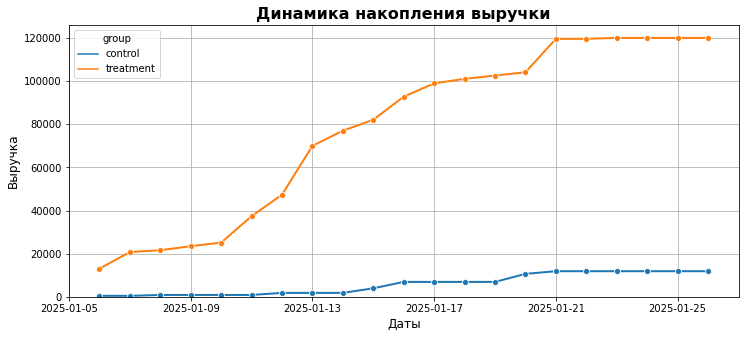

In [66]:
# Визуализируем кумулятивные данные для выручки
plt.figure(figsize=(12, 5))

sns.lineplot(data=df_metrics_cum, x='date', y='revenue', marker='o', hue='group', linewidth=2)

plt.title('Динамика накопления выручки', fontsize=16, weight='bold')
plt.xlabel('Даты', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

Бонус однозначно стимулирует покупки. Это приводит к кратному росту выручки. Метрика выглядит стабильно дивергентной, что говорит о сильном эффекте.

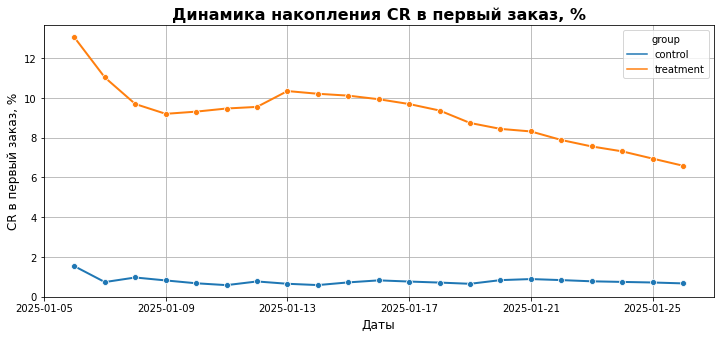

In [67]:
# Визуализируем кумулятивные данные для ключевой метрики CR в первый заказ
plt.figure(figsize=(12, 5))

sns.lineplot(data=df_metrics_cum, x='date', y='cr_to_first_purch', marker='o', hue='group', linewidth=2)

plt.title('Динамика накопления CR в первый заказ, %', fontsize=16, weight='bold')
plt.xlabel('Даты', fontsize=12)
plt.ylabel('CR в первый заказ, %', fontsize=12)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

CR у treatment в первые дни намного выше (начиная с 12–13%). По мере накопления данных метрика плавно снижается до 6.5–8.5%, но остается стабильно выше контроля на весь период.

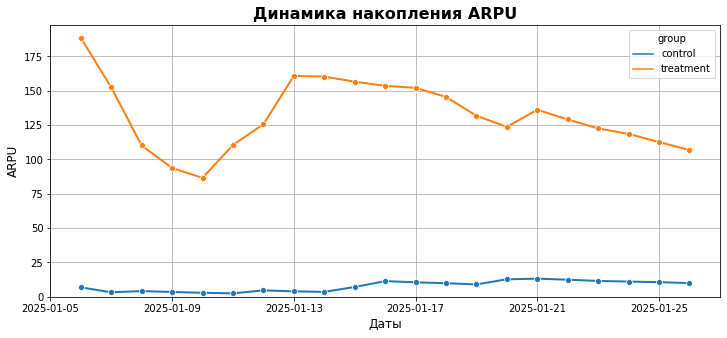

In [68]:
# Визуализируем кумулятивные данные для ключевой метрики ARPU
plt.figure(figsize=(12, 5))

sns.lineplot(data=df_metrics_cum, x='date', y='arpu', marker='o', hue='group', linewidth=2)

plt.title('Динамика накопления ARPU', fontsize=16, weight='bold')
plt.xlabel('Даты', fontsize=12)
plt.ylabel('ARPU', fontsize=12)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

У treatment ARPU колеблется, но уверенно в разы выше контроля. К концу эксперимента — есть тренд на снижение, но разрыв сохраняется.

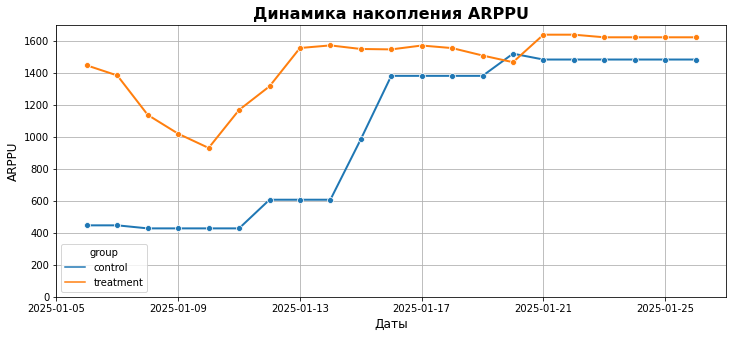

In [69]:
# Визуализируем кумулятивные данные для ключевой метрики ARPPU
plt.figure(figsize=(12, 5))

sns.lineplot(data=df_metrics_cum, x='date', y='arppu', marker='o', hue='group', linewidth=2)

plt.title('Динамика накопления ARPPU', fontsize=16, weight='bold')
plt.xlabel('Даты', fontsize=12)
plt.ylabel('ARPPU', fontsize=12)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

ARPPU treatment колеблется, несмотря на рост Control к 20 числу, остальные даты остается выше.

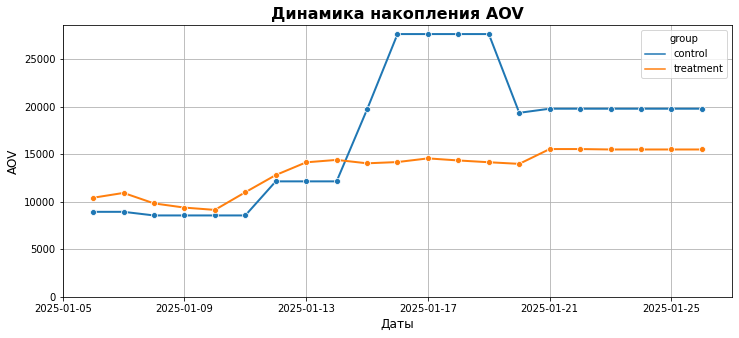

In [70]:
# Визуализируем кумулятивные данные для ключевой метрики AOV
plt.figure(figsize=(12, 5))

sns.lineplot(data=df_metrics_cum, x='date', y='aov', marker='o', hue='group', linewidth=2)

plt.title('Динамика накопления AOV', fontsize=16, weight='bold')
plt.xlabel('Даты', fontsize=12)
plt.ylabel('AOV', fontsize=12)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

Против ожидания, AOV выше в контрольной группе. Группа treatment имеет стабильный, но пониженный чек.

In [71]:
# Посчитаем ключевую, барьерную и вспомогательные метрики для контрольной и тестовой групп и абсолютную/относительную разницы
df_metrics = df_metrics_cum.iloc[40:, :10].set_index('group').T.copy()
df_metrics.columns.name = None
df_metrics = df_metrics.reset_index().rename(columns={'index': 'metrics'})

# Посчитаем разницу метрик между группами
df_metrics['abs_diff'] = df_metrics['treatment'] - df_metrics['control']
df_metrics['rel_diff_%'] = round(100 * df_metrics['abs_diff'] / df_metrics['control'], 2)

df_metrics

metrics        control     treatment      abs_diff  rel_diff_%
0                gmv  237233.220000  2.400070e+06  2.162836e+06      911.69
1            reg_usr    1187.000000  1.123000e+03 -6.400000e+01       -5.39
2          payer_usr       8.000000  7.400000e+01  6.600000e+01      825.00
3             orders      12.000000  1.550000e+02  1.430000e+02     1191.67
4            revenue   11861.661000  1.200035e+05  1.081418e+05      911.69
5               arpu       9.992975  1.068597e+02  9.686676e+01      969.35
6              arppu    1482.707625  1.621669e+03  1.389610e+02        9.37
7                aov   19769.435000  1.548432e+04 -4.285115e+03      -21.68
8  cr_to_first_purch       0.673968  6.589492e+00  5.915524e+00      877.72

Сформулируем статистичекую гипотезу для ключевой метрики между экспериментальными группами:
- H₀: cr_to_first_purch_control = cr_to_first_purch_treatment
- H₁: cr_to_first_purch_control < cr_to_first_purch_treatment

In [72]:
# Проведем z-тест пропорций для ключевой метрики - конверсии в первую покупку

n_reg_ctrl = df_metrics[df_metrics.metrics == 'reg_usr']['control']
n_reg_treatment = df_metrics[df_metrics.metrics == 'reg_usr']['treatment']

n_payers_ctrl = df_metrics[df_metrics.metrics == 'payer_usr']['control']
n_payers_treatment = df_metrics[df_metrics.metrics == 'payer_usr']['treatment']

# Z-test для пропорций
z_stat, p_value_cr = proportions_ztest(count=[n_payers_ctrl, n_payers_treatment], 
                                    nobs=[n_reg_ctrl, n_reg_treatment], 
                                    alternative='smaller')
print(f'p_value для cr_to_first_purch {p_value_cr[0]}')

p_value для cr_to_first_purch 7.966801261653676e-15


Для сравнения вспомогательных и барьерной метрик экспериментальных групп будем использоватть бутстрап.<br> 
Сформулируем статистические гипотезы для указанных метрик:
- H₀: ARPU_control = ARPU_treatment
- H₁: ARPU_control < ARPU_treatment


- H₀: ARPPU_control = ARPPU_treatment
- H₁: ARPPU_control < ARPPU_treatment


- H₀: AOV_control = AOV_treatment
- H₁: AOV_control < AOV_treatment


- H₀: Revenue_control = Revenue_treatment
- H₁: Revenue_control < Revenue_treatment

In [73]:
# Создадим функцию для расчета и визуализации результатов бутсрапа между эксп. группами, 95% доверительный интервал
np.random.seed(23)

def boot_diffs(control, treatment, metric_func, metric, n_iterations=1000):
    
    boot_diffs = [] 

    for i in range(n_iterations):
        # Формируем бутстрап выборки
        boot_control = np.random.choice(control, size=len(control), replace=True)
        boot_test = np.random.choice(treatment, size=len(treatment), replace=True)
    
        #Расчитаем метрику
        ctrl_metric = metric_func(boot_control)
        test_metric = metric_func(boot_test)
        
        # Добавляем разницу значений perc перцентиля тестовой и контрольной групп
        boot_diffs.append(test_metric - ctrl_metric)
    
    boot_diffs = np.array(boot_diffs)
    bound_ci = np.percentile(boot_diffs, 5)

    # Вывод 95% доверительного интервала
    print(f'Размер выборки в treatment - {len(treatment)}, Размер выборки в control - {len(control)}')
    print(f"{metric} контрольной группы: {ctrl_metric:.2f}")
    print(f"{metric} тестовой группы: {test_metric:.2f}")
    print(f"95%-й доверительный интервал разности {metric} (treatment - control) [{bound_ci:.2f}, {np.inf}]") 
    print('---------------------------------------------------')
    
    # Визуализация результатов бутстрапа разницы метрики тестовой и контрольной групп, 95% доверительный интервал
    plt.figure(figsize=(8, 6))
    
    sns.histplot(boot_diffs, bins=30, kde=True)
    plt.axvline(bound_ci, color='red', linestyle='--', label='Нижняя граница ДИ')
    plt.axvline(metric_func(treatment) - metric_func(control), color='black', linestyle='-', label='Фактическая разница')
    
    plt.title(f'Бутстрап разницы {metric} (treatment - control)')
    plt.xlabel(f'Разница {metric}')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

In [74]:
# Сформируем выборки для бутсрапа
arpu_treatment = df_analysis_AB[df_analysis_AB.group == 'treatment'].groupby('user_id', as_index=False)['total_price'].sum()
arpu_treatment['usr_amount'] = arpu_treatment['total_price'] * 0.05

arpu_control = df_analysis_AB[df_analysis_AB.group == 'control'].groupby('user_id', as_index=False)['total_price'].sum()
arpu_control['usr_amount'] = arpu_control['total_price'] * 0.05

arppu_treatment = df_analysis_AB[(df_analysis_AB.group == 'treatment') & 
                                (df_analysis_AB.is_buyer == 1)].groupby('user_id', as_index=False)['total_price'].sum()
arppu_treatment['payer_amount'] = arppu_treatment['total_price'] * 0.05

arppu_control = df_analysis_AB[(df_analysis_AB.group == 'control') & 
                                (df_analysis_AB.is_buyer == 1)].groupby('user_id', as_index=False)['total_price'].sum()
arppu_control['payer_amount'] = arppu_control['total_price'] * 0.05

aov_treatment = df_analysis_AB[(df_analysis_AB.group == 'treatment') & 
                                (df_analysis_AB.is_buyer == 1)]['total_price']
aov_control = df_analysis_AB[(df_analysis_AB.group == 'control') & 
                                (df_analysis_AB.is_buyer == 1)]['total_price']

revenue_treatment = df_analysis_AB[df_analysis_AB.group == 'treatment']['total_price'].fillna(0) * 0.05
revenue_control = df_analysis_AB[df_analysis_AB.group == 'control']['total_price'].fillna(0) * 0.05

Размер выборки в treatment - 1123, Размер выборки в control - 1187
ARPU контрольной группы: 7.29
ARPU тестовой группы: 88.35
95%-й доверительный интервал разности ARPU (treatment - control) [64.05, inf]
---------------------------------------------------


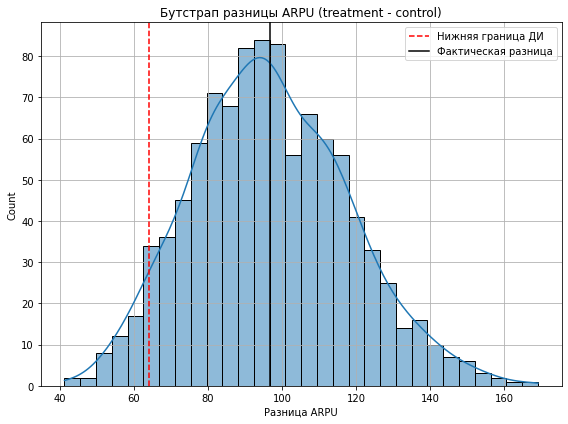

Размер выборки в treatment - 74, Размер выборки в control - 8
ARPPU контрольной группы: 1292.81
ARPPU тестовой группы: 2789.15
95%-й доверительный интервал разности ARPPU (treatment - control) [-557.96, inf]
---------------------------------------------------


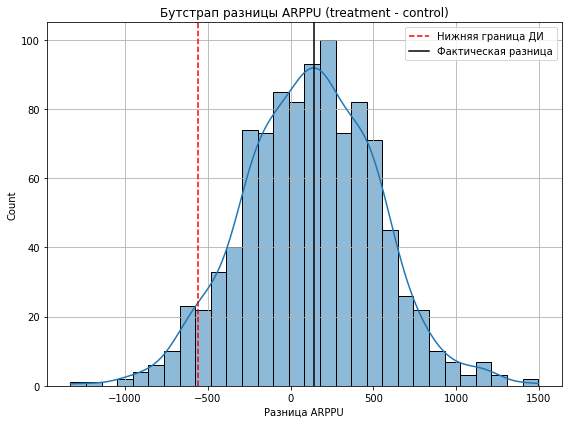

Размер выборки в treatment - 155, Размер выборки в control - 12
AOV контрольной группы: 17354.97
AOV тестовой группы: 14925.37
95%-й доверительный интервал разности AOV (treatment - control) [-13950.38, inf]
---------------------------------------------------


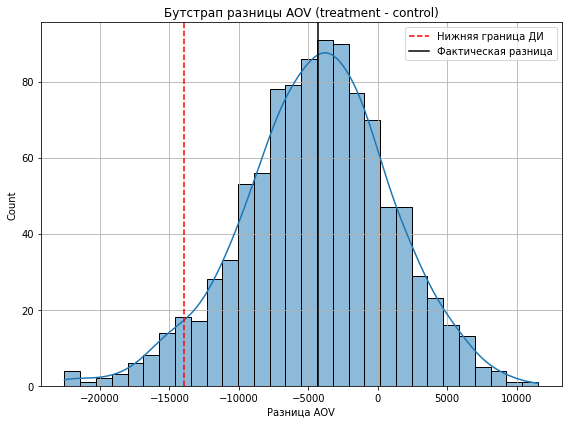

Размер выборки в treatment - 1204, Размер выборки в control - 1191
Revenue контрольной группы: 19182.89
Revenue тестовой группы: 101700.74
95%-й доверительный интервал разности Revenue (treatment - control) [81456.03, inf]
---------------------------------------------------


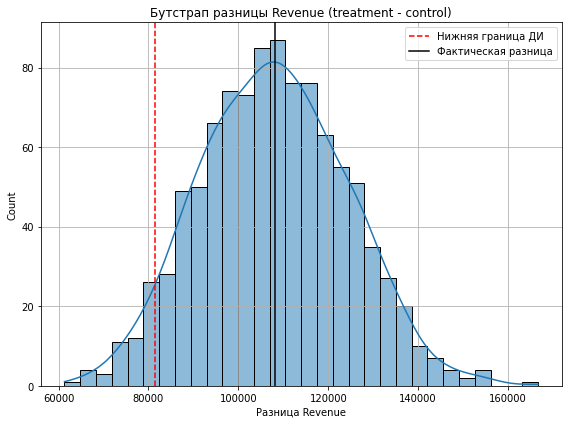

In [75]:
# Расчетаем и визуализируем результатов бутсрапа между эксп. группами, 95% доверительный интервал
boot_diffs(arpu_control['usr_amount'], arpu_treatment['usr_amount'], np.mean, 'ARPU', n_iterations=1000)
boot_diffs(arppu_control['payer_amount'], arppu_treatment['payer_amount'], np.mean, 'ARPPU', n_iterations=1000)
boot_diffs(aov_control, aov_treatment, np.mean, 'AOV', n_iterations=1000)
boot_diffs(revenue_control, revenue_treatment, np.sum, 'Revenue', n_iterations=1000)

In [78]:
# Т.к. для ARPPU и AOV размеры контрольных выборок довольно малы, доверительные интервалы бутсрапа будут нестабильны и широки, 
# и значит интерпретация — крайне ограничена. Дополнительно используем тест Манна Уитни, т.к. он более устойчив к малым выборкам.

stat, p_arppu = mannwhitneyu(arppu_control['payer_amount'], arppu_treatment['payer_amount'], alternative='less')
stat, p_aov = mannwhitneyu(aov_control, aov_treatment, alternative='less')
print(f"Mann–Whitney U тест: ARPPU: p-value = {p_arppu:.4f}, AOV: p-value = {p_aov:.4f}")

Mann–Whitney U тест: ARPPU: p-value = 0.9014, AOV: p-value = 0.8836


В данном эксперименте использовалась одна основная метрика — конверсия в первую покупку среди новых пользователей с TikTok. Именно по этой метрике проверялась статистическая значимость гипотезы, и принималось решение об успехе теста.

Дополнительно рассчитывались вспомогательные метрики (ARPU, ARPPU, AOV) — они рассматривались не как цели теста, а как интерпретирующие метрики, помогающие понять, за счёт чего изменяется поведение пользователей: растёт ли выручка, меняется ли средний чек и т. д.

Мы применили иерархический принцип анализа:
- Сначала проверяется основная гипотеза — рост конверсии,
- Только если этот эффект подтверждён статистически, анализируются остальные метрики.

Такой подход позволяет не использовать формальные поправки на множественные сравнения, так как основной риск ложноположительных выводов (ошибка I рода) остаётся под контролем: ключевое решение принимается только по одной метрике, а остальные не используются для выбора победителя.

Барьерная метрика (общая выручка) также анализировалась отдельно: она использовалась не для оценки эффекта, а для проверки отсутствия критического падения, то есть не требовала множественной коррекции значимости.

## Выводы по этапу 5

*Основная метрика* — конверсия в первую покупку — показала статистически значимый рост в тестовой группе (p < 0.001).

*Вспомогательные метрики:*
- ARPU: демонстрирует статистически значимый рост 
- Несмотря на рост выручки и конверсии, анализ ARPPU и среднего чека (AOV) показал, что размеры трат у покупающих пользователей в тесте статистически не выше, чем в контрольной группе. Причина — малое количество покупателей в контроле, что ограничивает силу теста. Дополнительные проверки с непараметрическим тестом подтвердили: данные не позволяют говорить о росте этих метрик с высокой уверенностью. При этом показатели не ухудшились, что подтверждает успешность эксперимента.

*Барьерная метрика* (комиссионная выручка сервиса): статистически значимо возросла, что исключает негативный эффект от использования бонуса.

**Гипотеза подтверждена:** предоставление бонуса на первую покупку значимо повысило конверсию, общую выручку, ARPU, и не вызвало негативного эффекта по барьерной метрике.
Несмотря на незначимый результат по ARPPU/AOV, бизнес-цели выполнены, и тест можно считать успешным.

**Рекомендации:**
- Раскатать механику бонуса на новых пользователей из TikTok.
- Масштабировать механику на другие каналы привлечения.
- Оптимизация бонуса по размеру и условиям.
- Повторить эксперимент на большем горизонте / сегментах.

ARPPU и AOV не показали статистического роста — это может говорить о том, что пользователи используют бонус для минимальной покупки, не увеличивая чек, либо просто из-за слишком малого числа пользователей в контрольной группе.